## Chapter 8: Linear regression

#  8.4  Feature scaling via standard normalization

In this Section we discuss the benefits of *normalizing input features* - also called *feature scaling* - for linear regression in terms of how it helps drastically improve training speed when using gradient descent (and coordinate descent methods).  This is extremely important since - as we will see going forward - input normalization is one of simplest yet most effective 'optimization tricks' one can use when employing gradient descent to tune *any supervised learning model*.  This 'optimization trick' will also prove especially important when we deal with nonlinear supervised models in the future - like e.g., *deep networks* - where training via gradient descent (and its close relatives) is essential.

In this Section we first explore the benefit of standard normalization via a number of examples involving single and multi-input regression datasets.  Afterwards we summarize our findings and discuss the general benefits of input normalization, and end with a more formal mathematical argument that helps explain these benefits from a formal point of view.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib

# demos for this notebook
regress_plotter = superlearn.lin_regression_demos
feature_scaling_tools = superlearn.feature_scaling_tools
optimizers = optlib.optimizers
static_plotter = optlib.static_plotter.Visualizer()
cost_lib = superlearn.cost_functions
datapath = '../../mlrefined_datasets/superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# other functionality 
import copy

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 8.4.1 Feature scaling for single input datasets

Below we load in and show a dataset we wish to perform linear regression on.  A quick glance at the data and we know that - if tuned properly - a linear regression will fit to this dataset exceedingly well, as the data appears to be roughly distributed on a line.

<IPython.core.display.Javascript object>


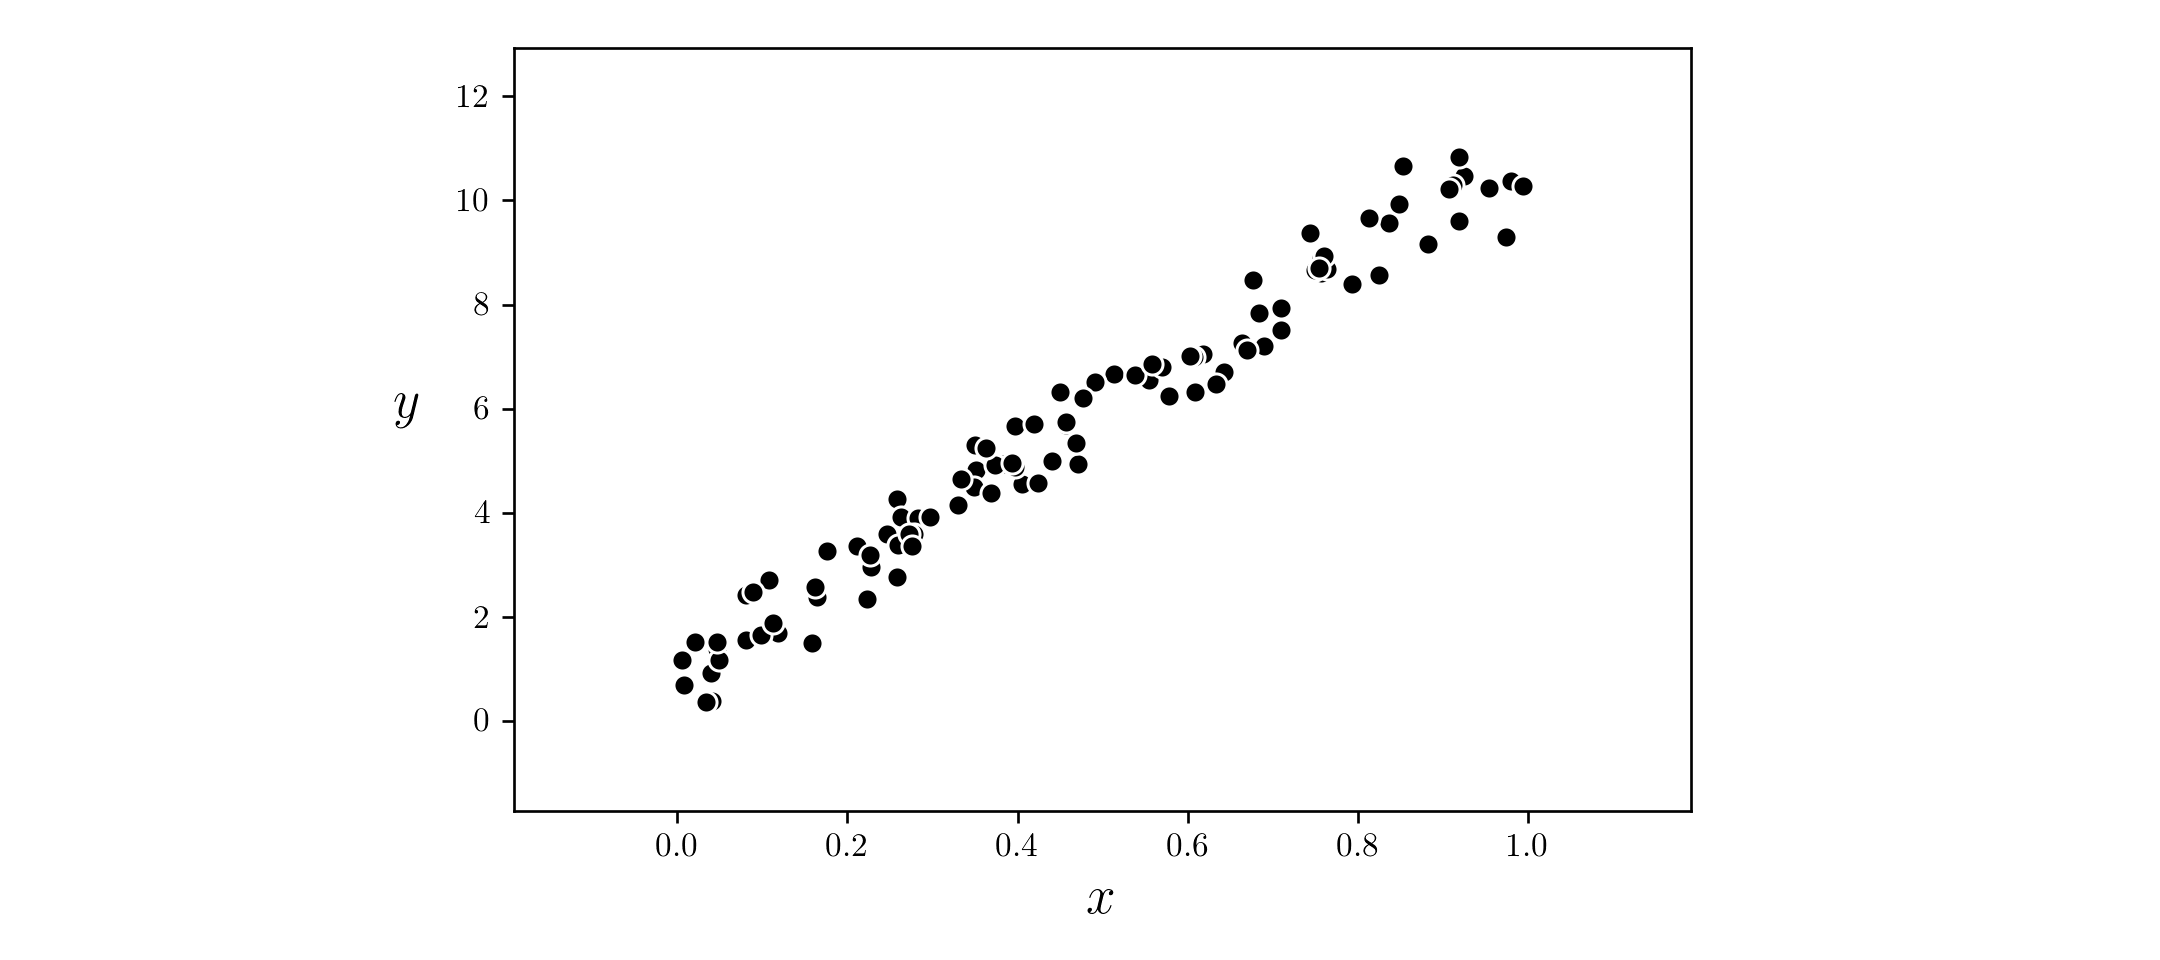

In [7]:
## This code cell will not be shown in the HTML version of this notebook
# load data
data = np.loadtxt( datapath + 'unnorm_linregress_data.csv',delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

Since this is a low dimensional example with only two parameters to learn (the bias and slope of a best fit line) let us take a look at its associated Least Squares cost function.  Below we plot its contours in the usual fashion - with darker blue regions corresponding to larger points on the cost surface, and conversely lighter regions indicating lower points on the cost function.

in minimizing the Least Squares cost function using a simple linear regression dataset - which we load in / show below.  A quick glance at this dataset and we can tell that linear regression will provide  

<IPython.core.display.Javascript object>


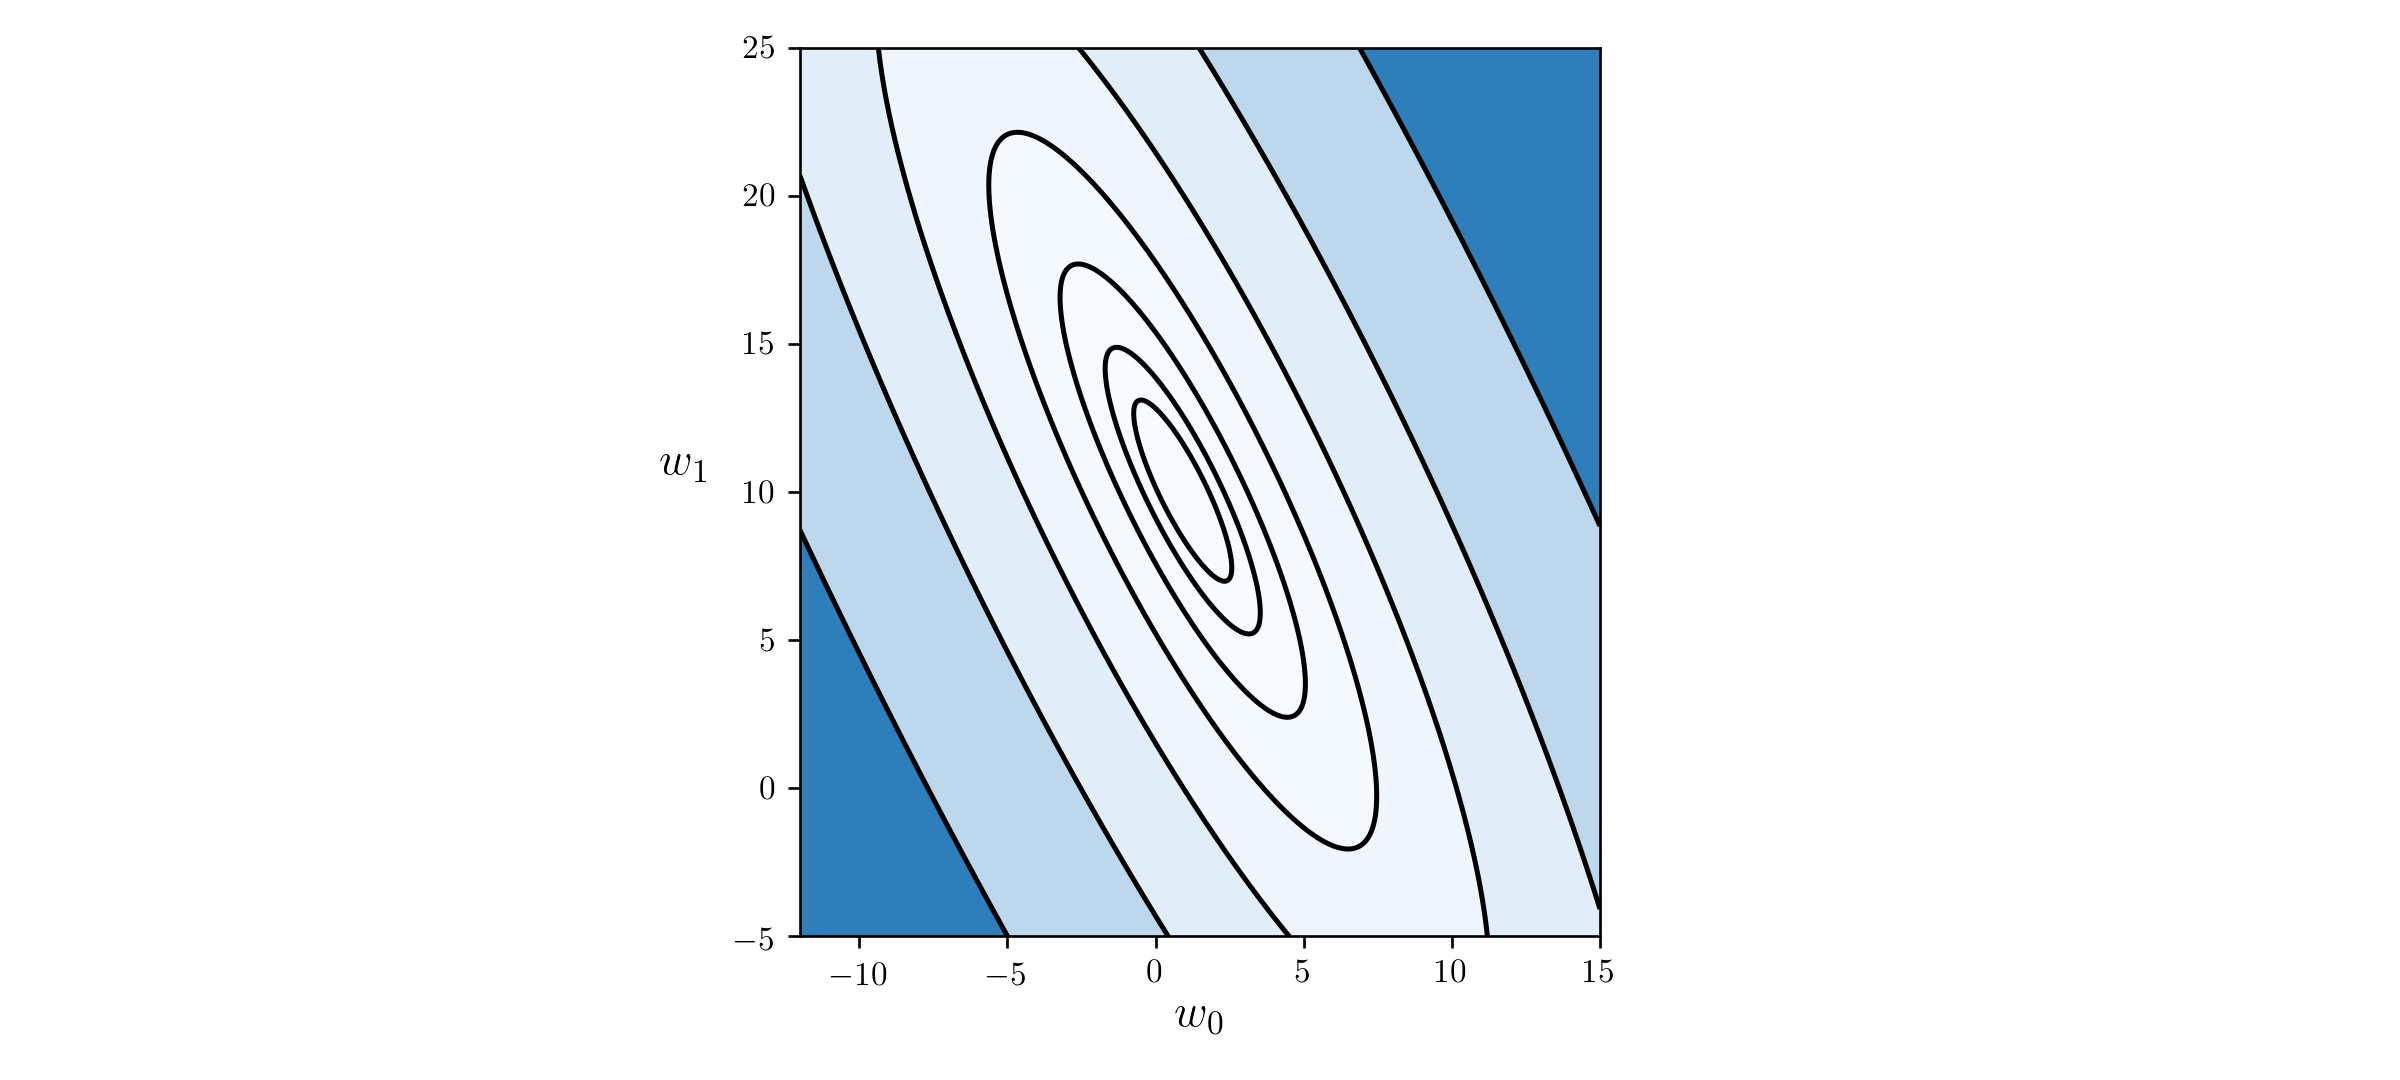

In [9]:
## This code cell will not be shown in the HTML version of this notebook
# an implementation of the least squares cost function for linear regression, precisely
# what was shown in Section 8.1 but here pulled in from a backend file
least_squares = cost_lib.choose_cost(x,y,'least_squares')

# show the contours of an input function over a desired viewing range
static_plotter.two_input_contour_plot(least_squares,[],xmin = -12,xmax = 15,ymin = -5,ymax = 25,num_contours = 7,show_original = False)

Notice how **elliptical** the contours of this cost function are - these create a long narrow valley along the long axis of the ellipses.  

While we can minimize this cost function using a variety of techniques, in this Section we will focus on employing gradient descent.  While we can certainly minimize this Least Squares cost using gradient descent, as discussed in Section 6.4 this algorithm progresses quite slowly when applied to minimize a cost functions like the one shown above (with its long narrow valley).  So unless we luck out and initialize directly along the *short axes* of such an elliptical contour-having cost function, gradient descent will need to take a large number of steps to reach an approximate global minimum.  

We illustrate this fact by showing a run of $100$ gradient descent steps initialized at the point $\mathbf{w}^0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$.  Here we use a fixed steplength parameter $\alpha = 10^{-1}$.  Here $10^{-1}$ was the largest value of $\alpha$ of the form $10^{-\gamma}$ we found that produced convergence from this initialization (larger values of $\alpha$ caused gradient descent to diverge).  

<IPython.core.display.Javascript object>


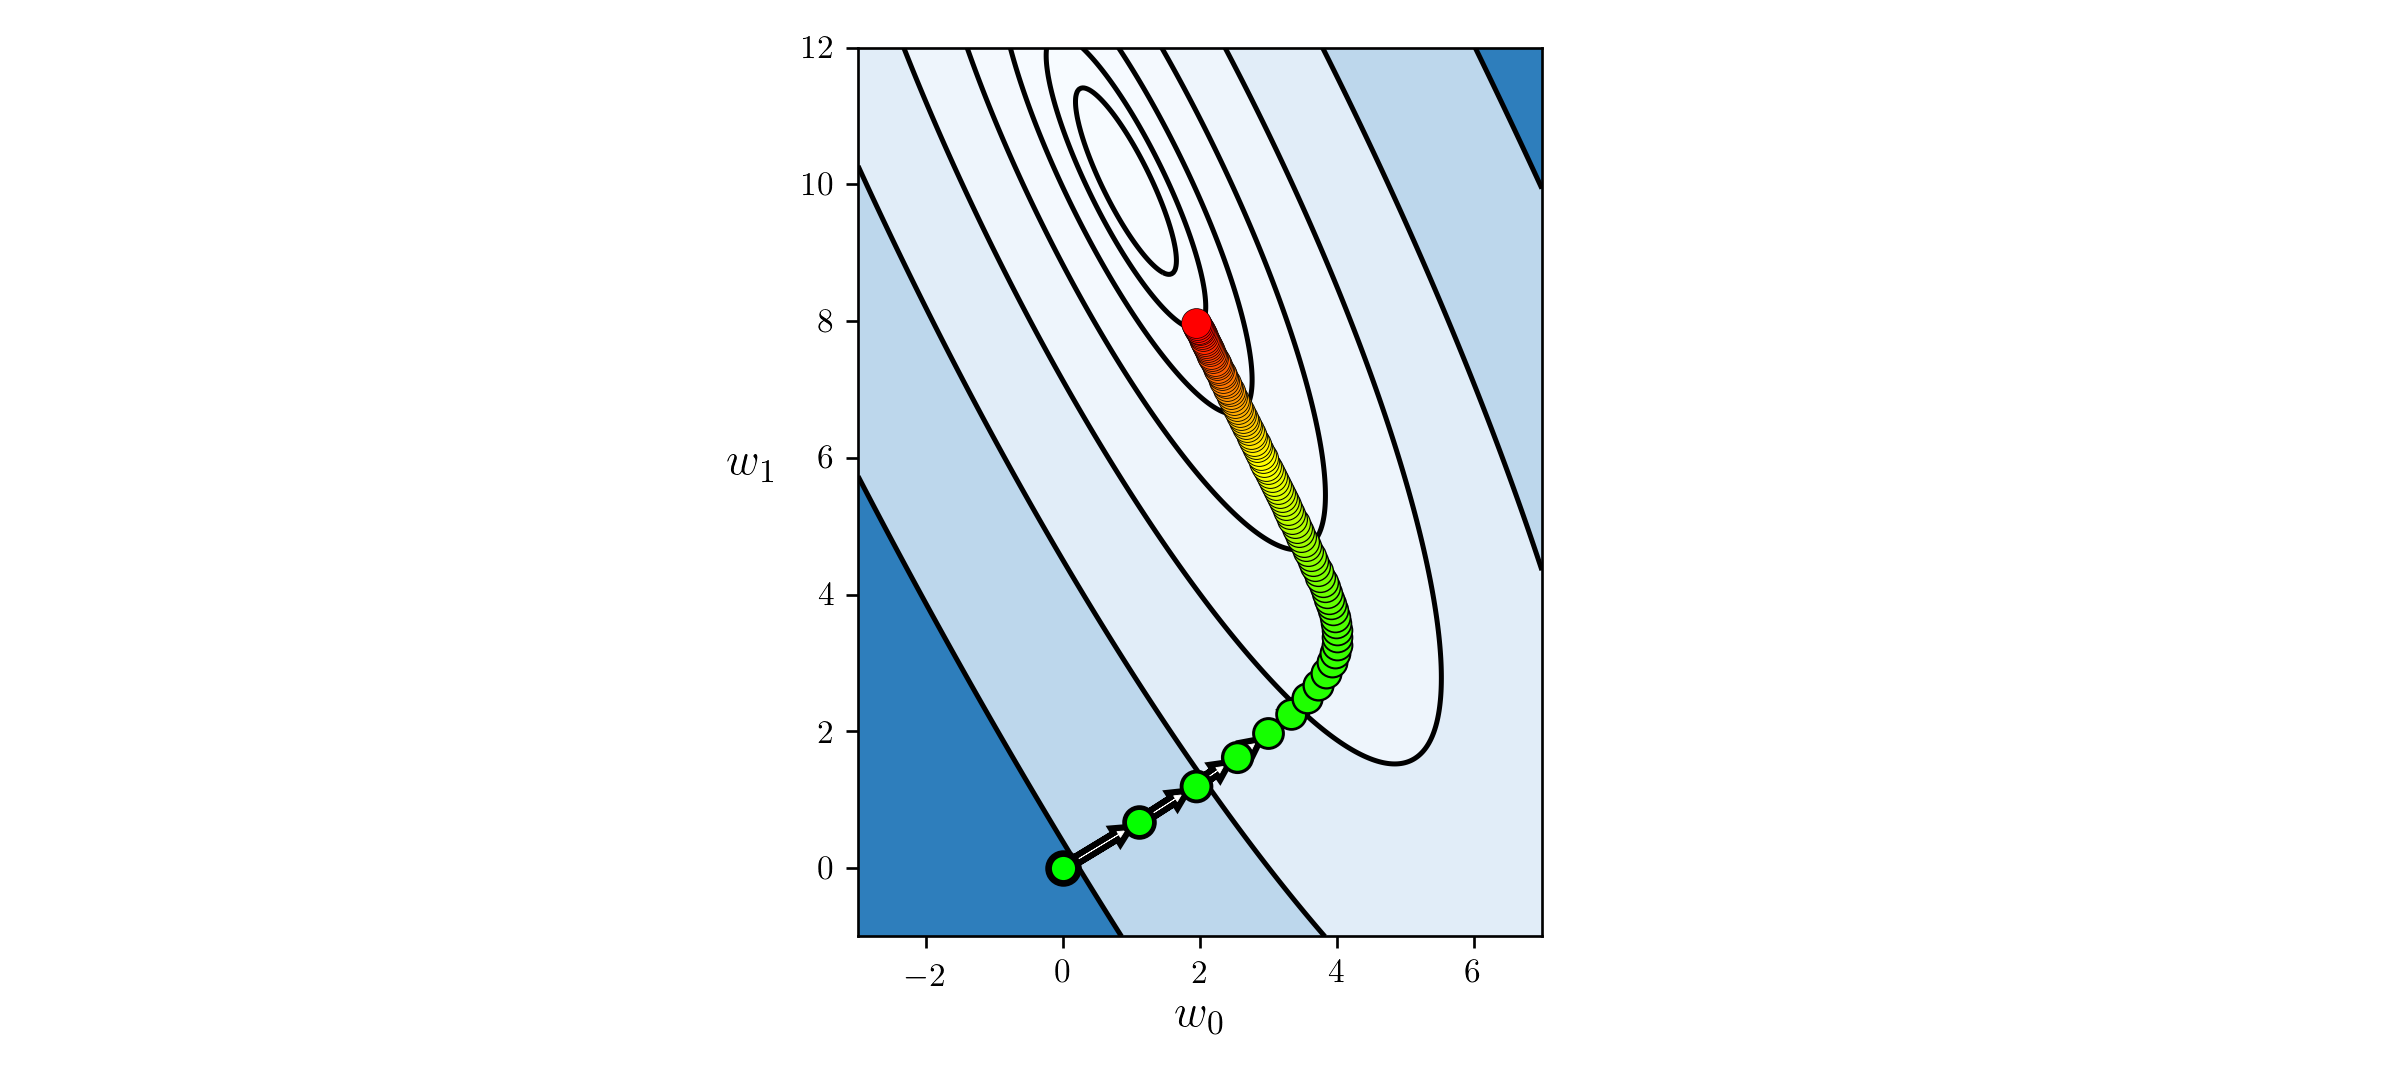

In [17]:
## This code cell will not be shown in the HTML version of this notebook
# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; w = np.array([0.0,0.0])[:,np.newaxis]; max_its = 100; alpha_choice = 10**(-1);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# show run on contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -3,xmax = 7,ymin = -1,ymax = 12,num_contours = 7,show_original = False)

Here as usual the steps are colored from green to red as gradient descent begins (green) to when it ends (red).  From this perspective we can see that we still have a way to travel to reach the minimum of the cost function.  Moreover, gradient descent is naturally slowing down as we approach the global minimum here - so we will need quite a few additional steps to reach an appropriate solution.

Plotting the line given by the final set of weights learned in this run of gradient descent - those associated with the final red point plotted on the contour plot above - we can see that the fact that these weights lie so far from the true minimum of the cost function truly affect the line's quality - we get poor fit considering how simple the dataset is.

<IPython.core.display.Javascript object>


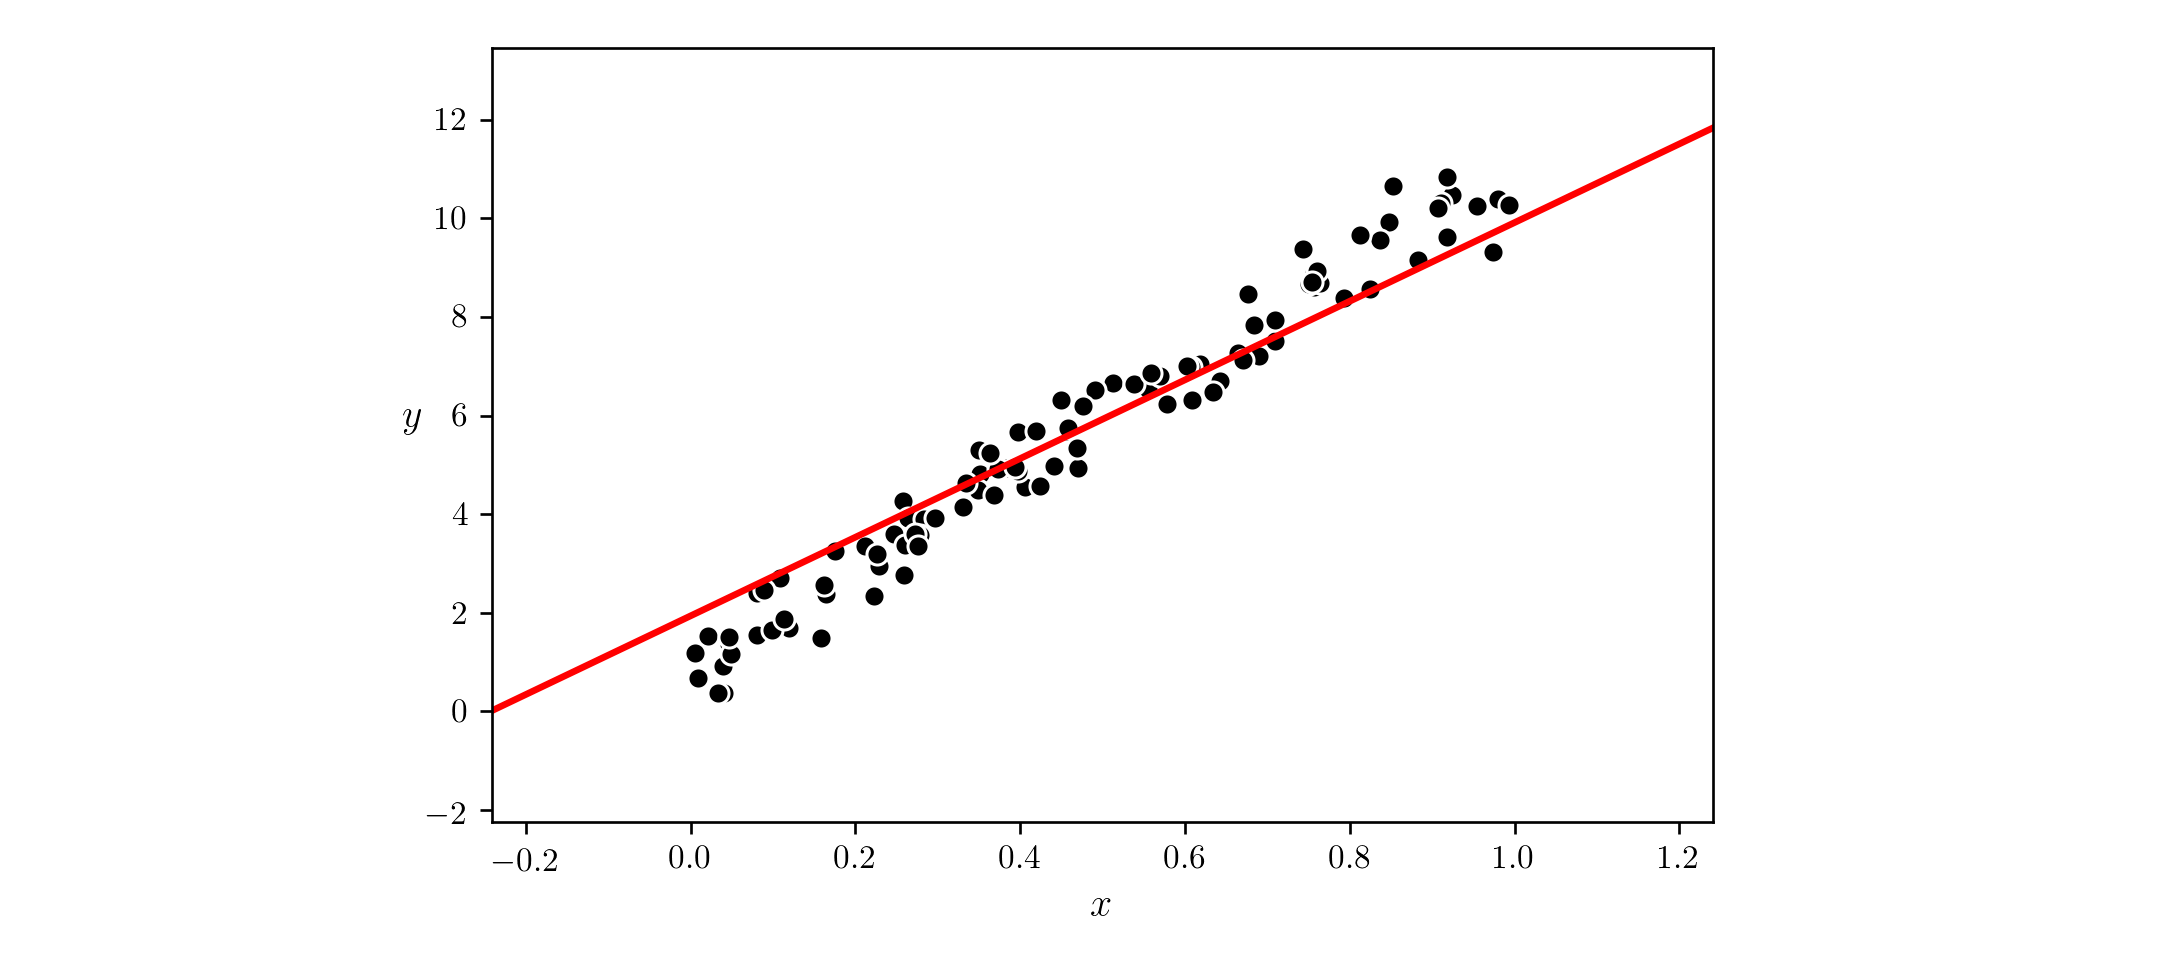

In [18]:
## This code cell will not be shown in the HTML version of this notebook
# the original data and best fit line learned from our gradient descent run
ind = np.argmin(cost_history)
least_weights = weight_history[ind]
demo.plot_fit(plotting_weights = [least_weights],colors = ['r'])

We can actually make an extremely simple adjustment of the data ameliorates this issue significantly, altering the shape of our Least Squares cost function so that its contours are much more *circular* (thus making it considerably easier for gradient descent to find global minima).  This simple adjustment is called *standard normalization*.  In particular, we normalize our inputs to have *zero mean and unit standard deviation*. 

 What does this look like?  Well we just replace each input $x_p$ point with its mean centered unit deviation analog as 

\begin{equation}
x_p \longleftarrow \frac{x_p - \mu}{\sigma}
\end{equation}

where the sample mean of the inputs $\mu$ is defined as 

\begin{equation}
\mu = \frac{1}{P}\sum_{p=1}^{P}x_p \\
\end{equation}

and the sample standard deviation of the inputs $\sigma$ is defined as 

\begin{array}
\
\sigma = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_p - \mu \right)^2}.
\end{array}

We call this simple normalization scheme *standard normalization*.

As we will see below for the particular dataset we are currently studying, this simple normalization 'trick' has a profound impact on the shape of our cost function.  Also note: this normalization scheme is *invertible*, meaning that after performing it we can always return to our original data by simple re-multiplying a normalized input by the original standard deviation and adding the original mean. 

Below we implement this normalization scheme.  Below we create a short `Python` function called `standard_normalizer` that creates this normalization schemes, returning a function `normalizer` (which normalizes a set of input data by subtracting its mean and dividing off its standard deviation).  We also provide an `inverse_normalizer` for reversing this procedure.

In [19]:
# standard normalization function 
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

In [20]:
# return normalization functions based on input x
normalizer,inverse_normalizer = standard_normalizer(x)

# normalize input by subtracting off mean and dividing by standard deviation
x_normalized = normalizer(x)

Now we form a Least Squares cost function with our normalized input, with the output un-changed.

With our cost function formed we now plot its contours, just as done previously.  As you can see - amazingly - the contours of this Least Squares cost (with normalized input) are perfectly circular.  No long narrow valleys can ever exist in such a function, and so gradient descent can much more rapidly minimize this cost.

<IPython.core.display.Javascript object>


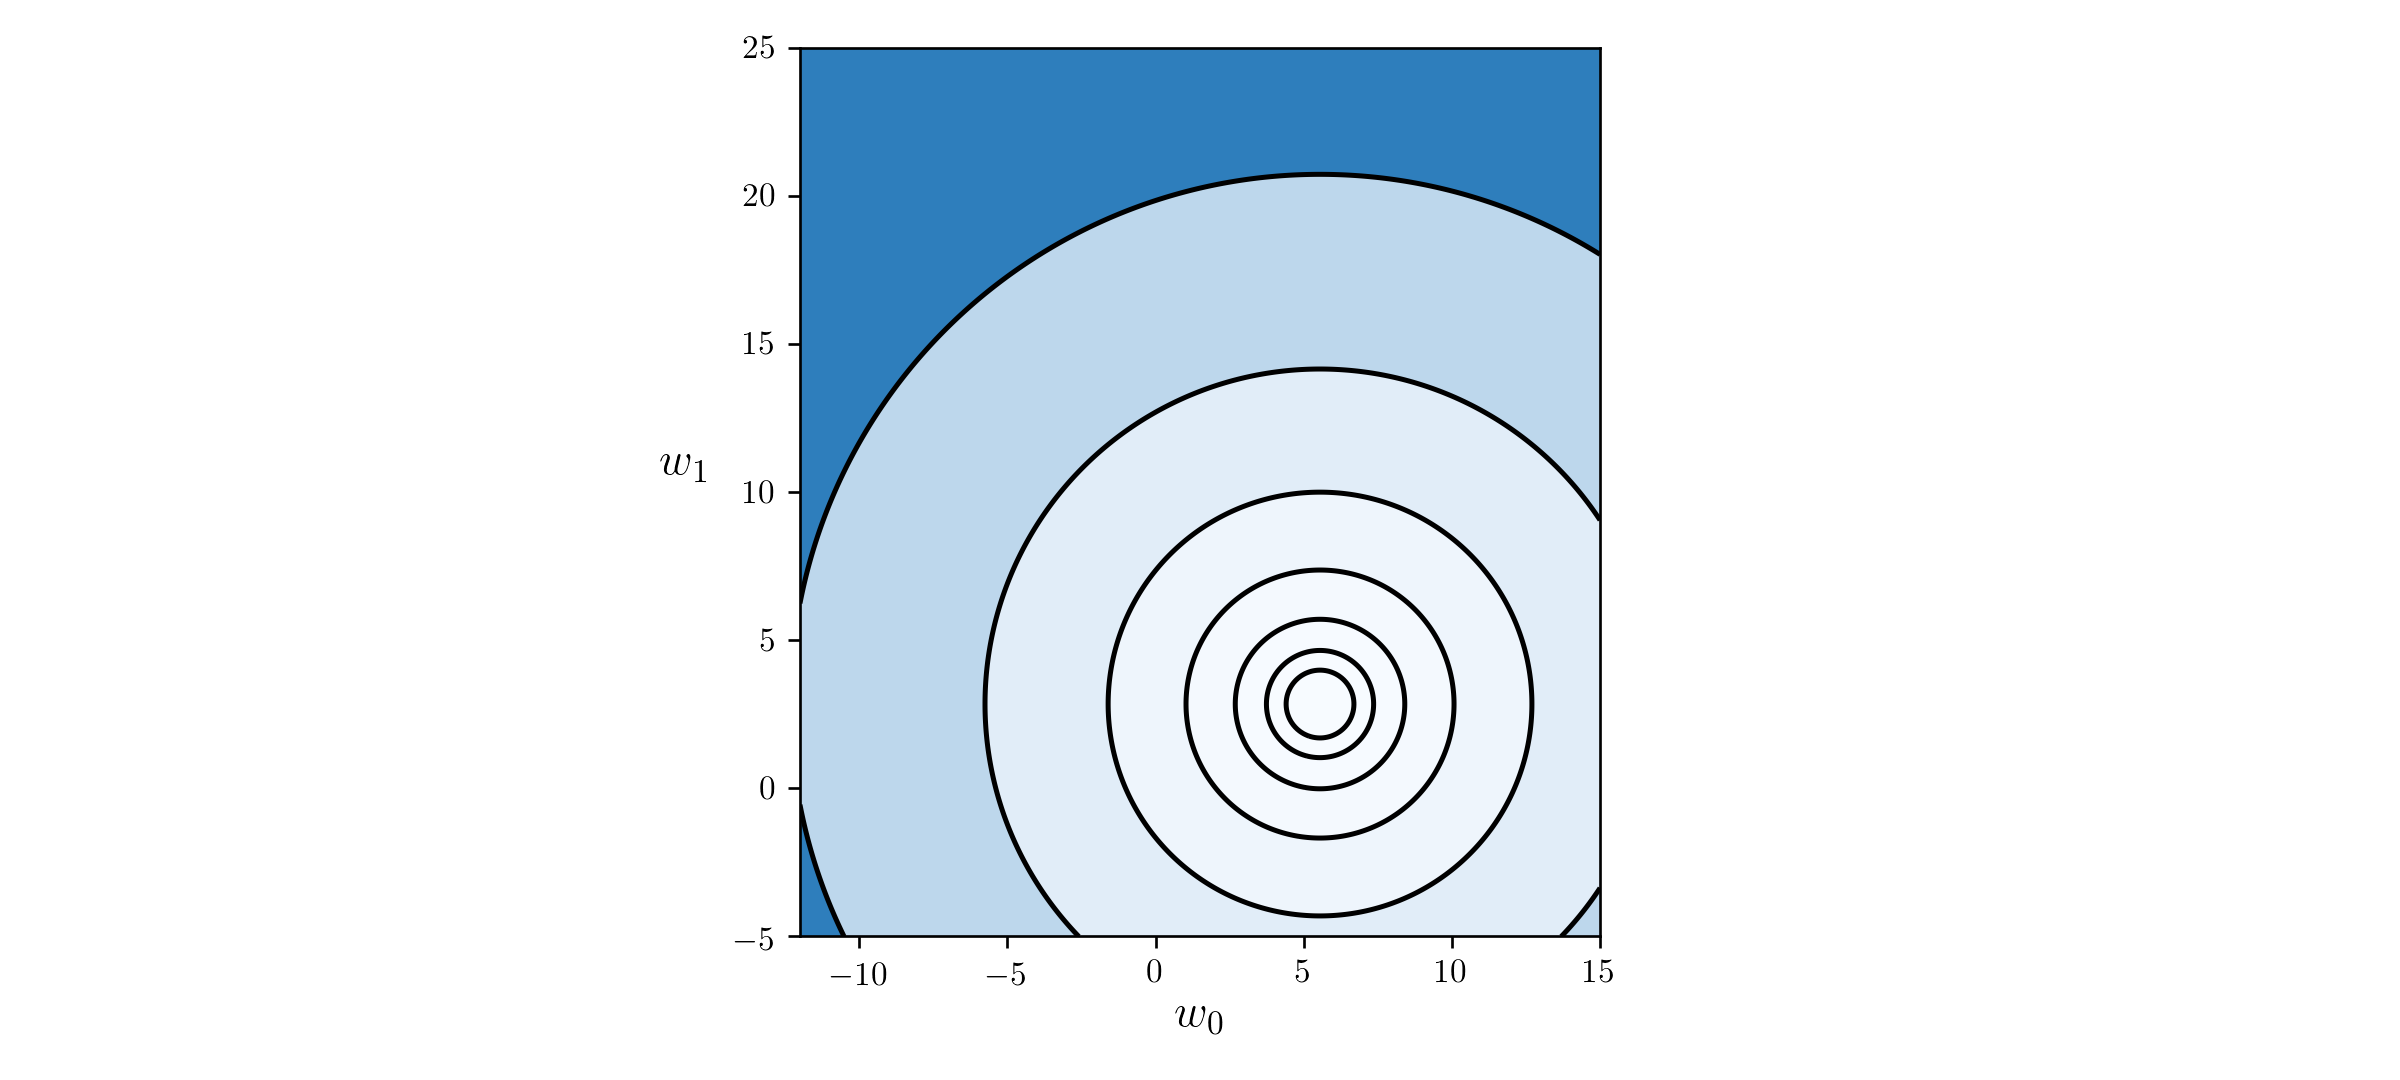

In [22]:
## This code cell will not be shown in the HTML version of this notebook
# an implementation of the least squares cost function for linear regression, precisely
# what was shown in Section 8.1 but here pulled in from a backend file
least_squares_2 = cost_lib.choose_cost(x_normalized,y,'least_squares')

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_contour_plot(least_squares_2,[],xmin = -12,xmax = 15,ymin = -5,ymax = 25,num_contours = 7,show_original = False)

Below we show an animation where we form a sequence of Least Squares cost functions using a convex combination of the original and normalized data 

\begin{equation}
\left(1 - \lambda\right)x_p + \lambda \left( \frac{x_p - \mu}{\sigma} \right)
\end{equation}

where $\lambda$ ranges from $0$ (i.e., we use the original input) to $\lambda = 1$ (where we use the normalized versions).  Plotting the contour of each Least Squares cost for a $50$ evenly spaced values of $\lambda$ between $0$ and $1$ shows how the original Least Squares cost function is transformed by normalizing the input.  You can use the slider below to transition between the contours of the original cost function (when the slider is all the way to the left) and cost function taking in normalized input (when the slider is all the way to the right).  


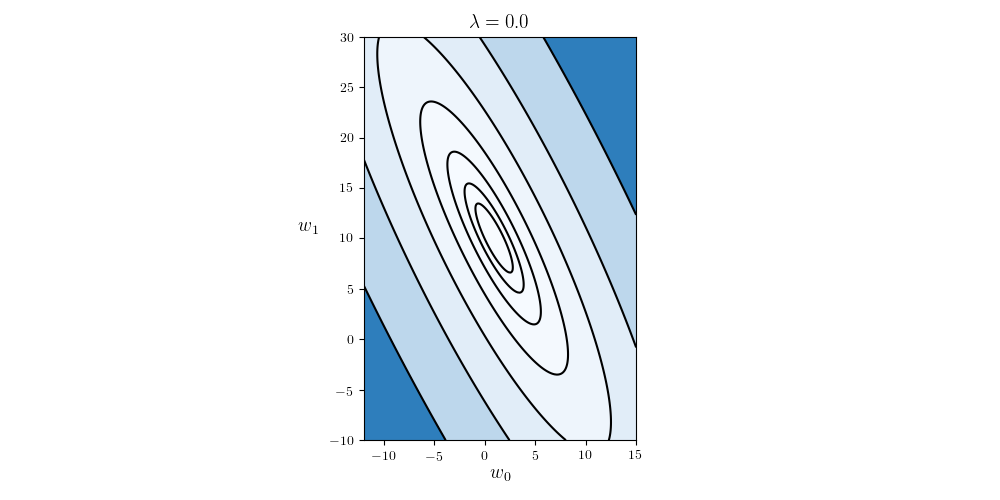
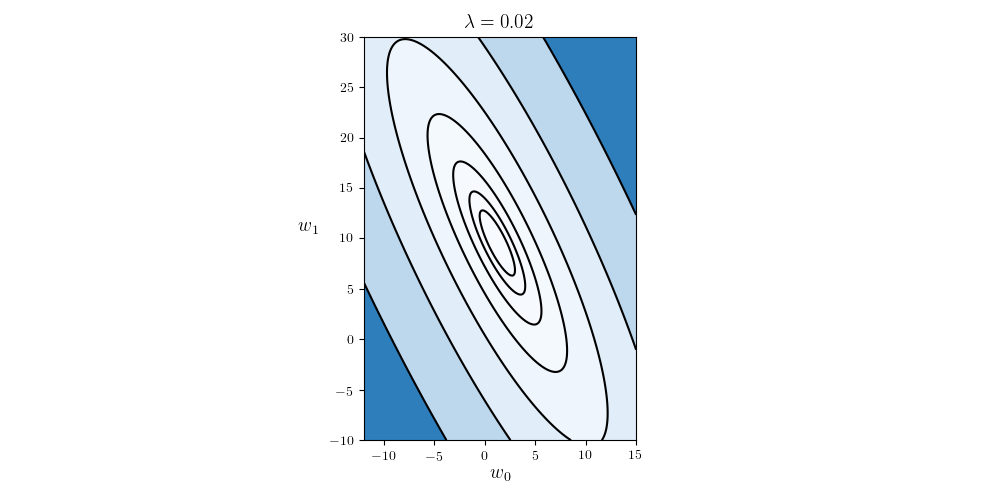
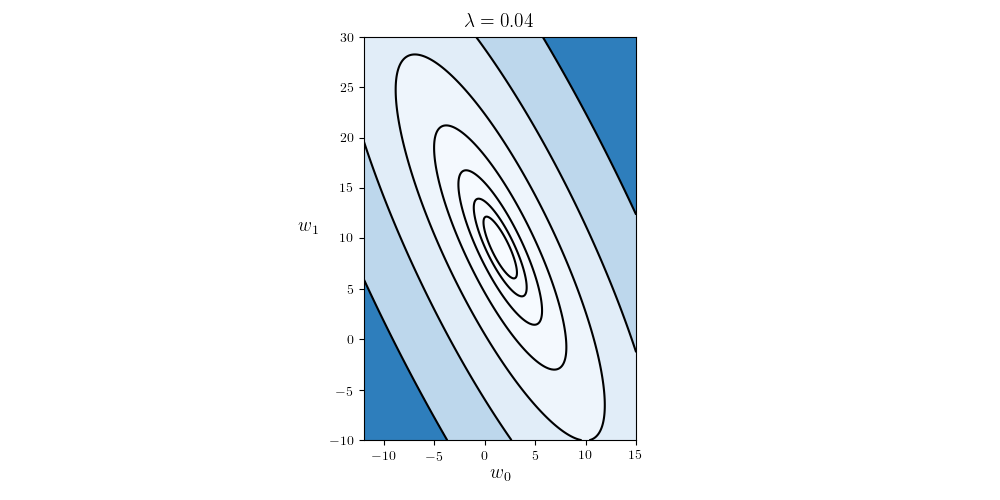
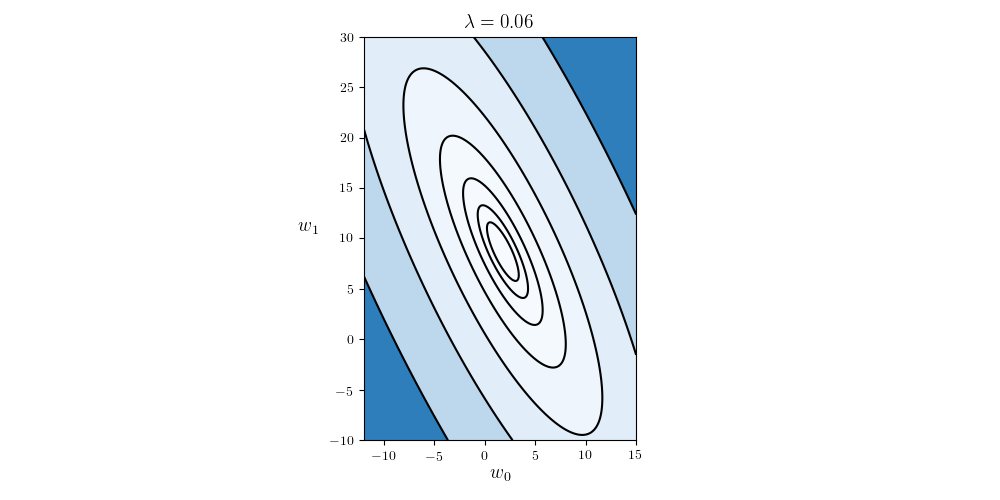
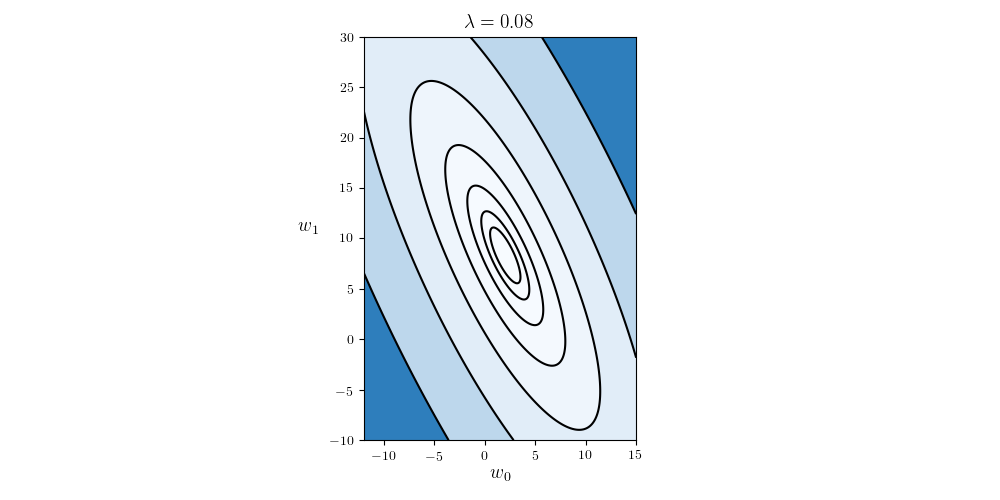
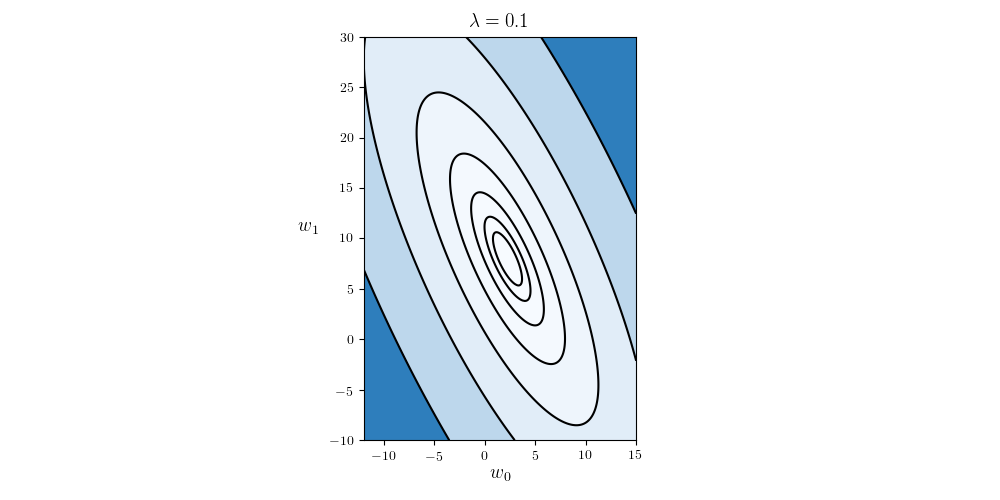
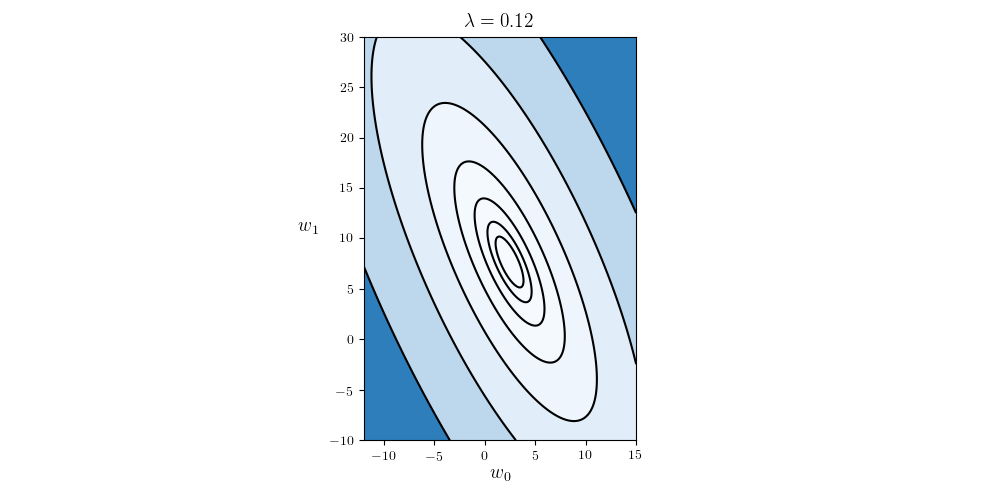
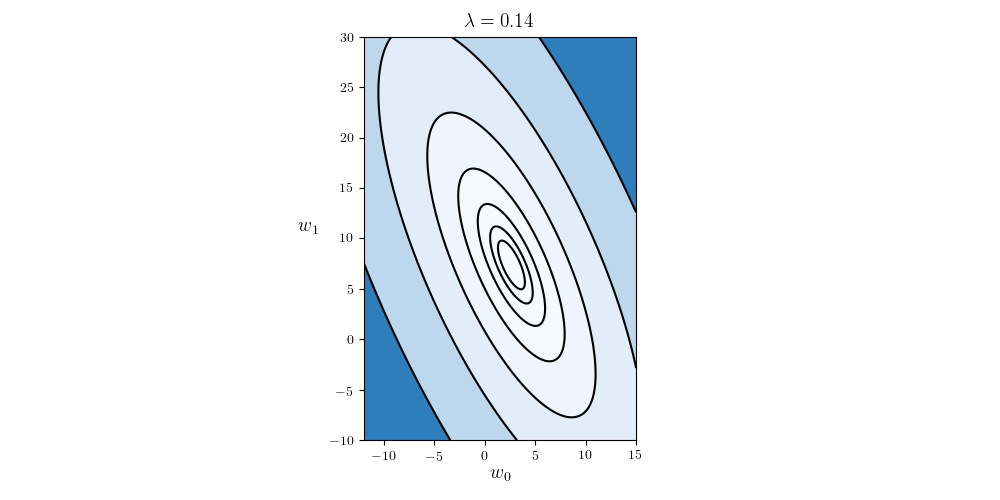
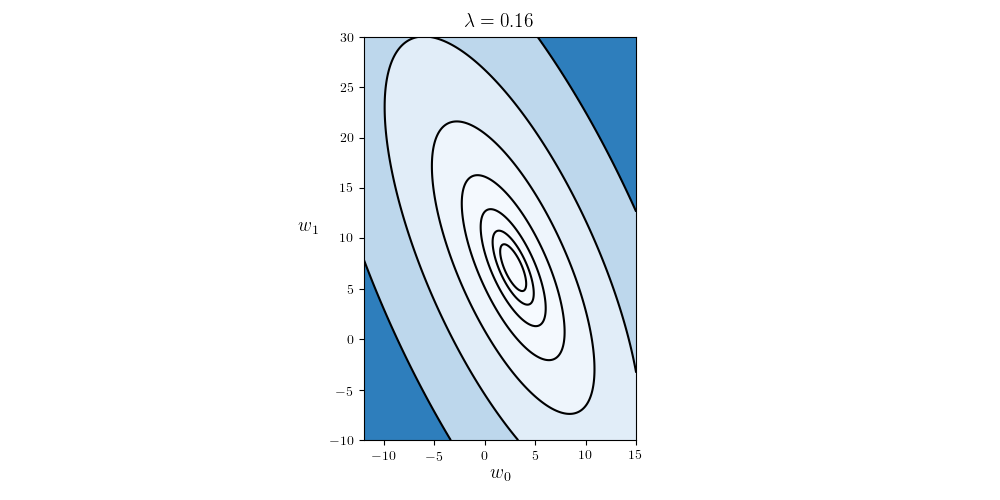
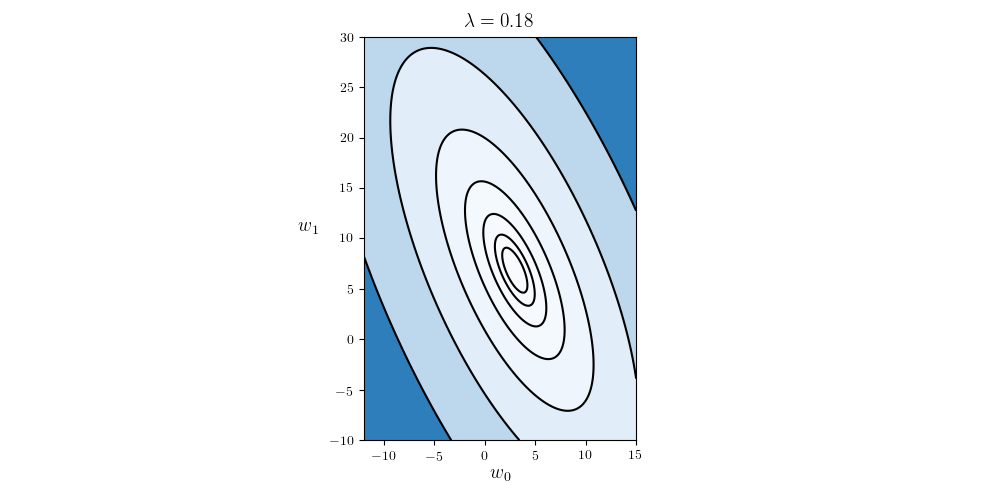
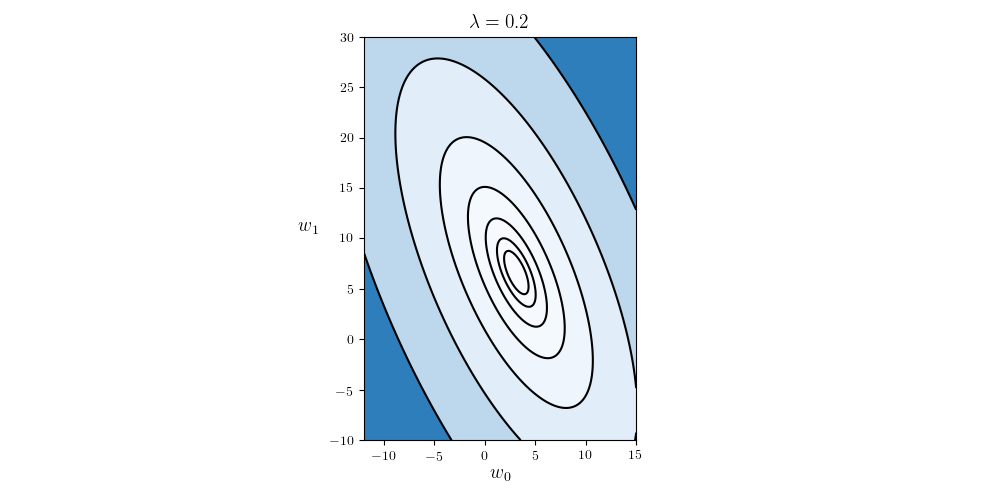
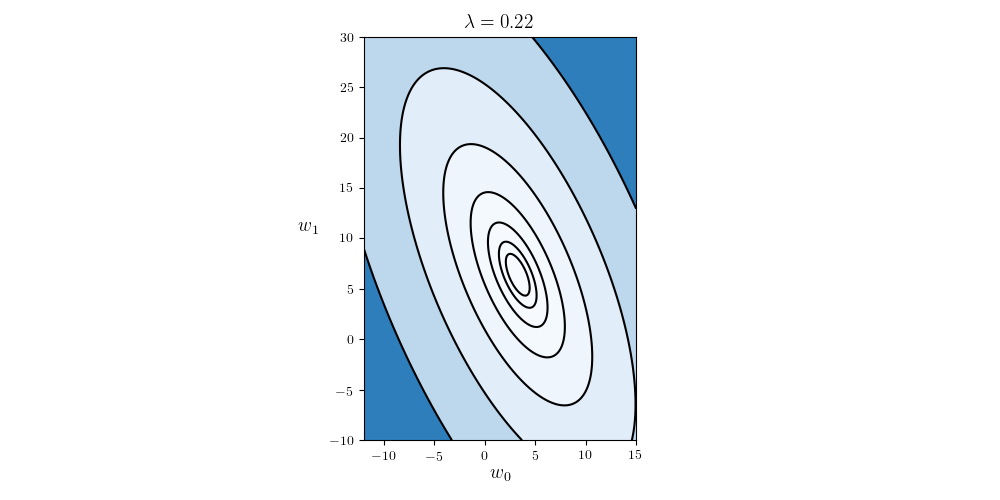
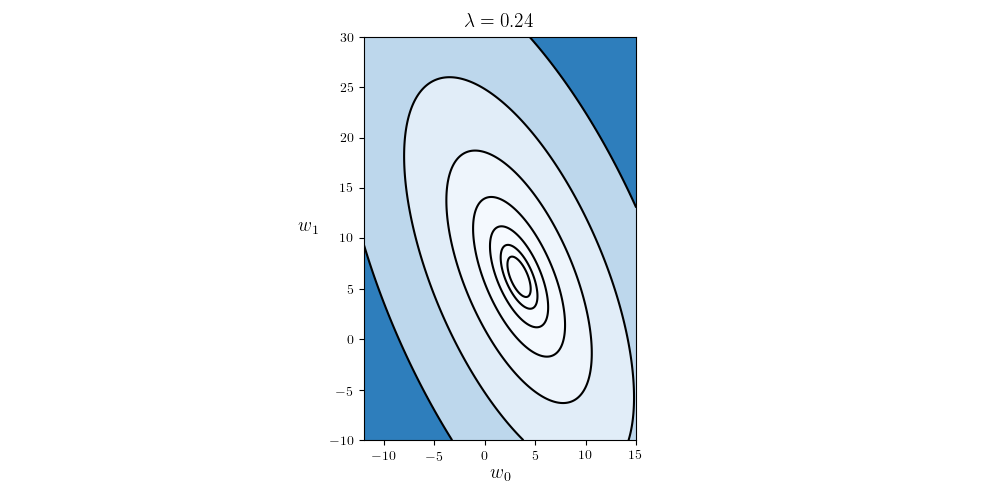
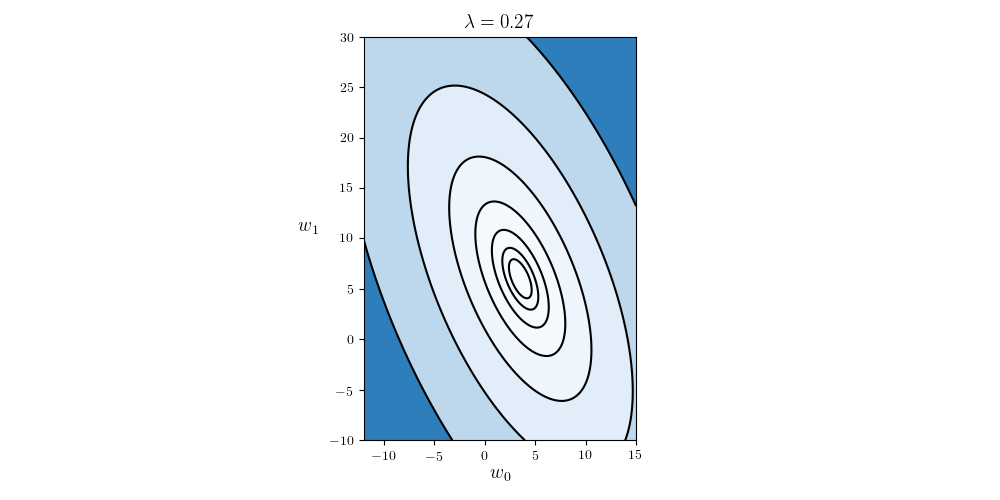
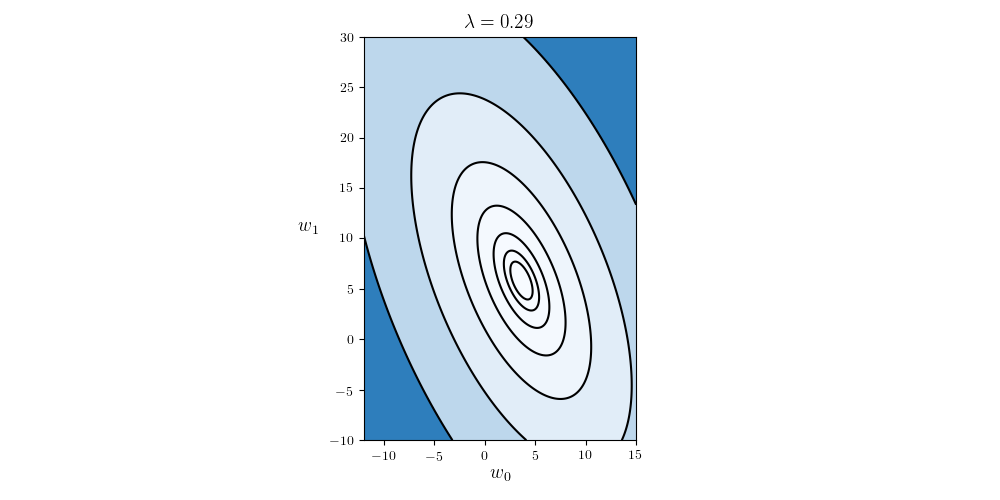
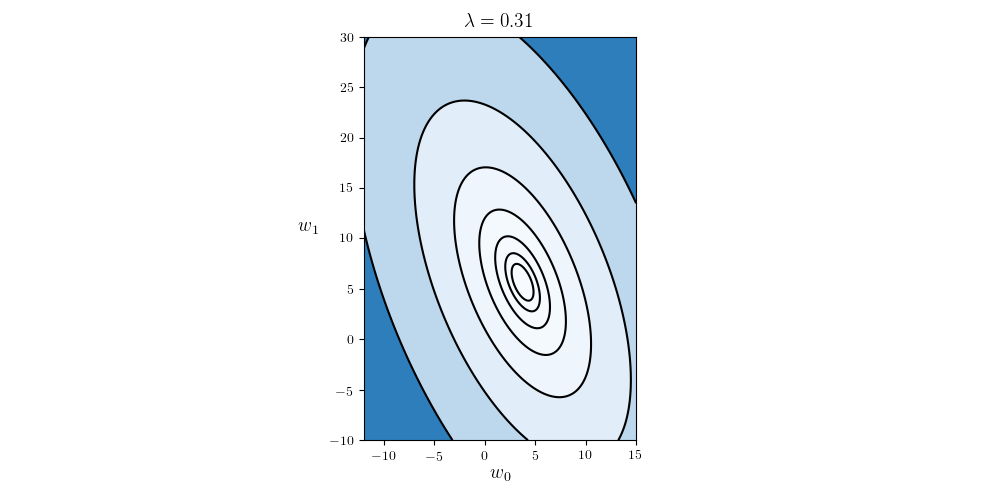
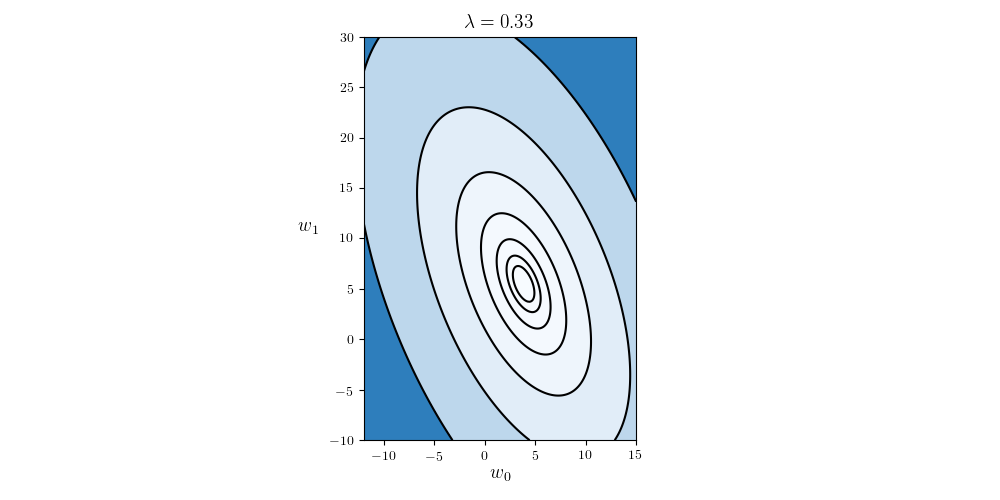
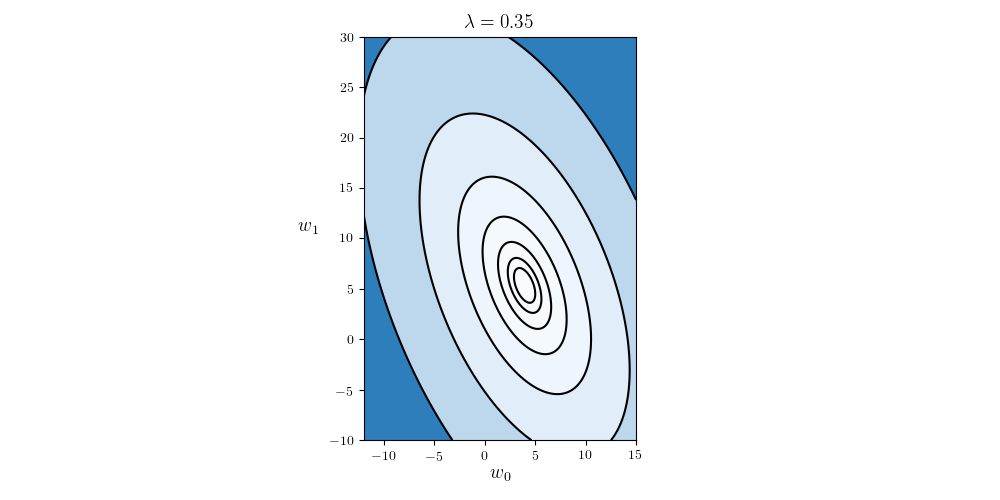
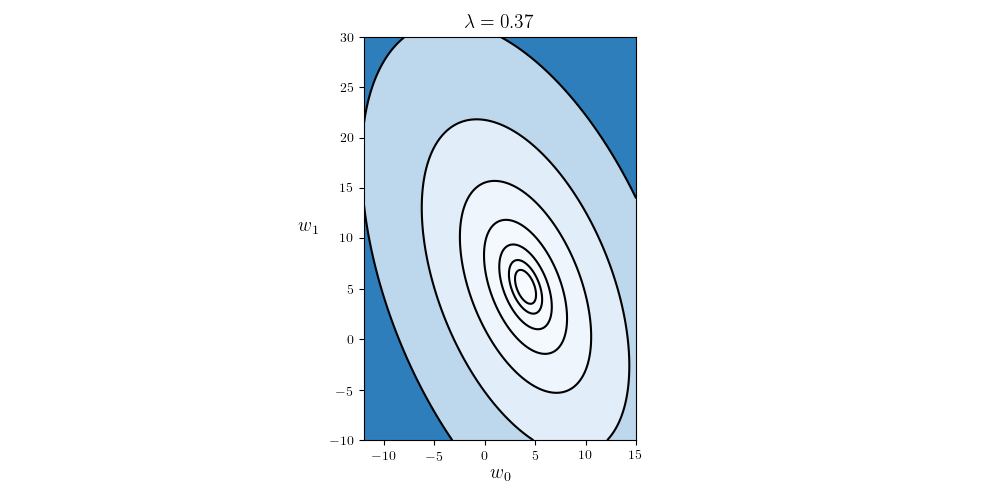
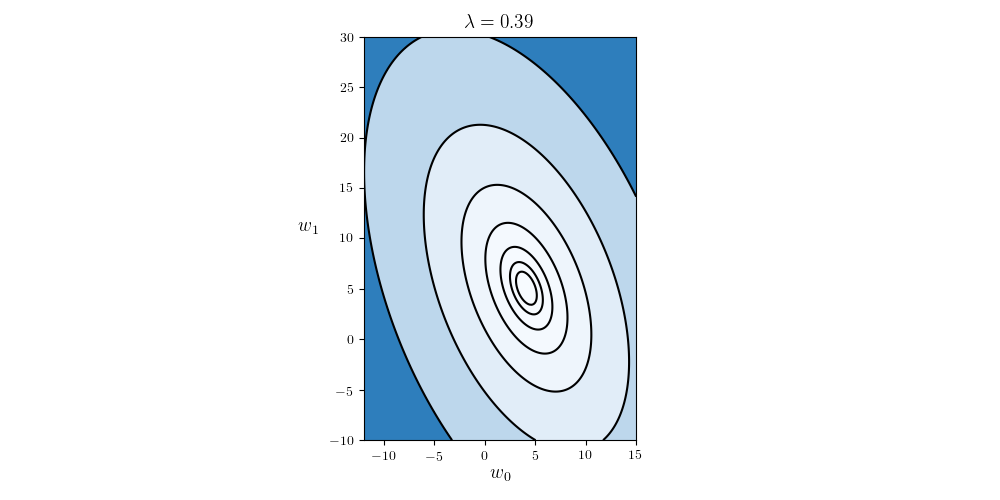
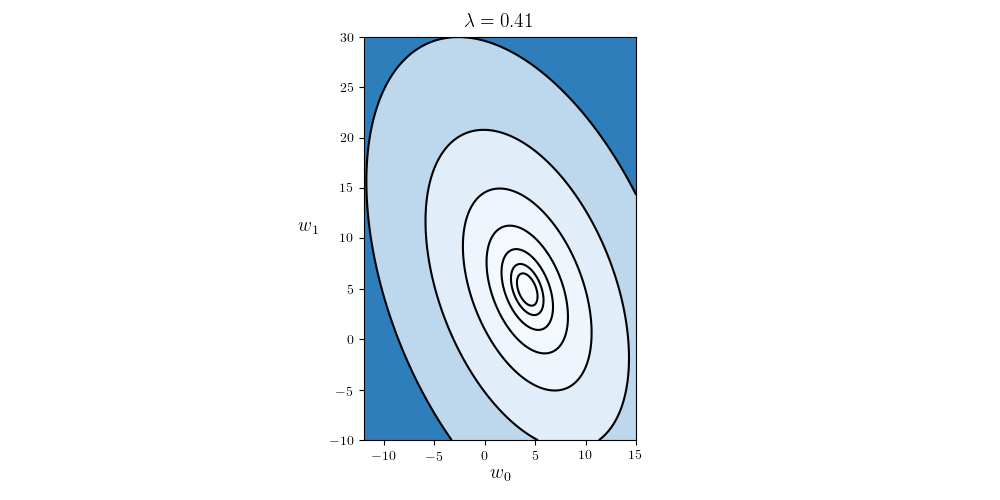
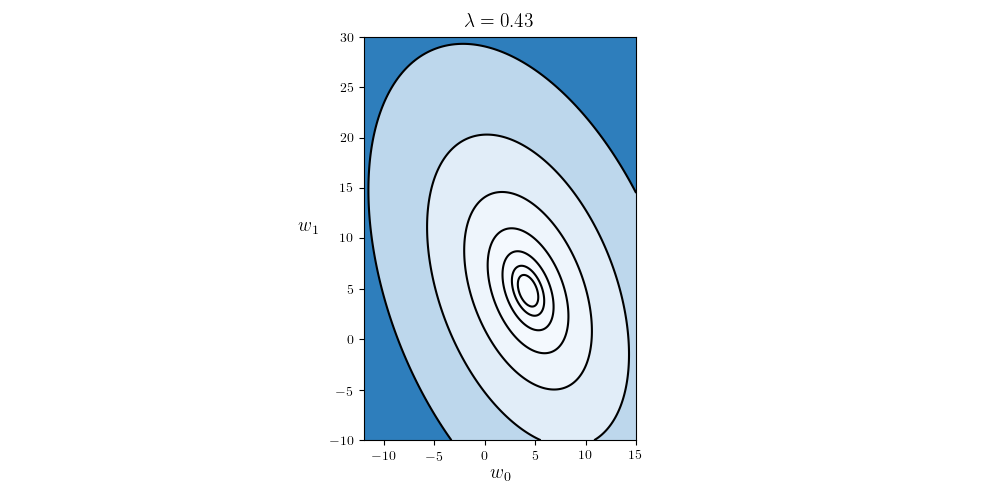
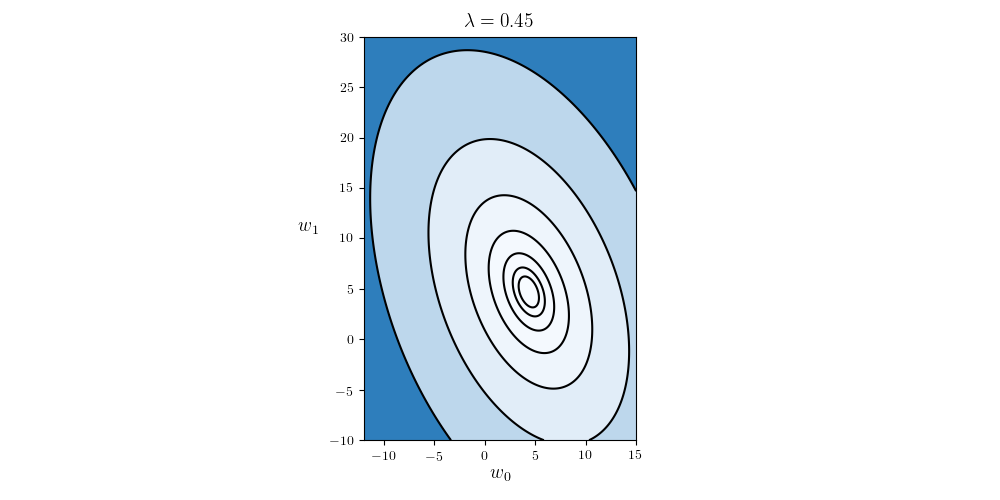
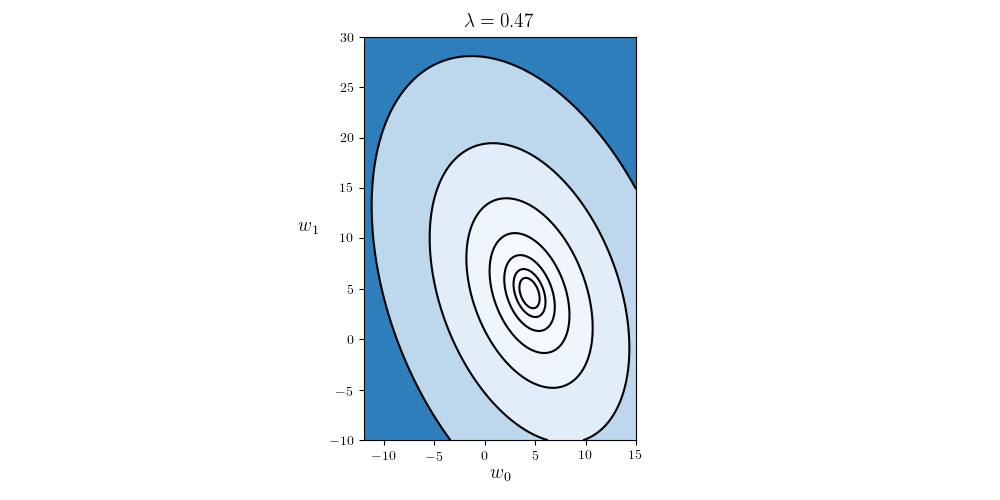
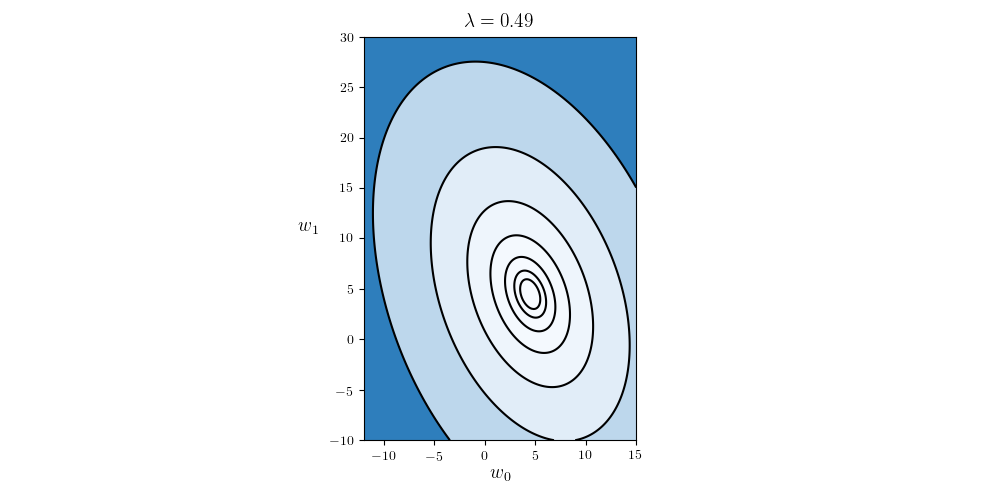
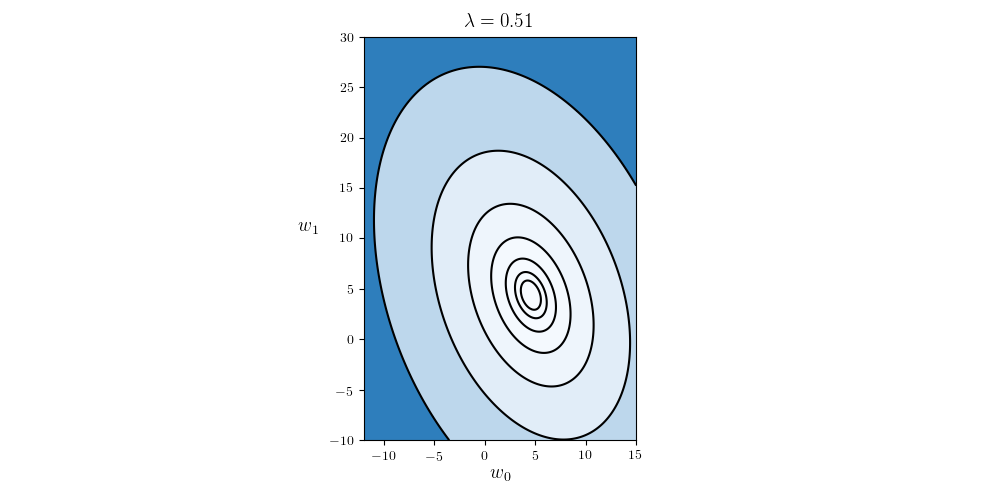
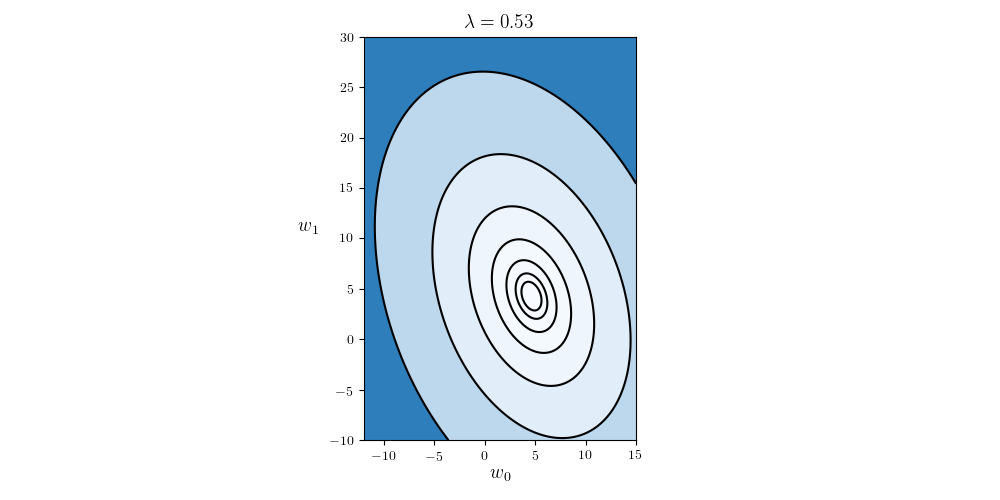
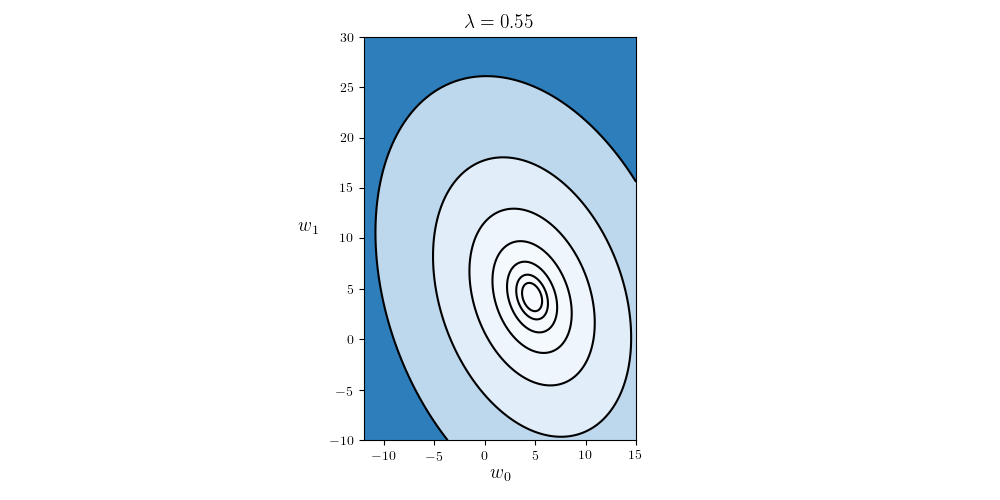
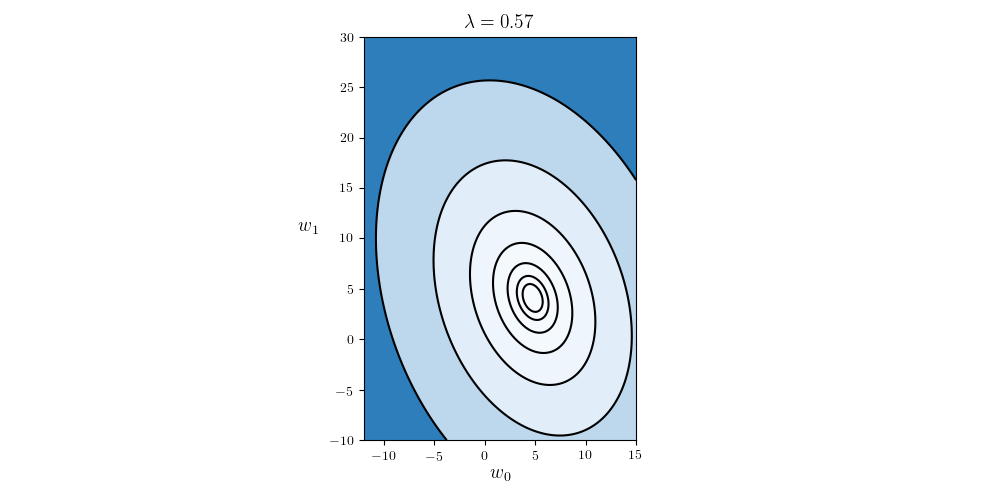
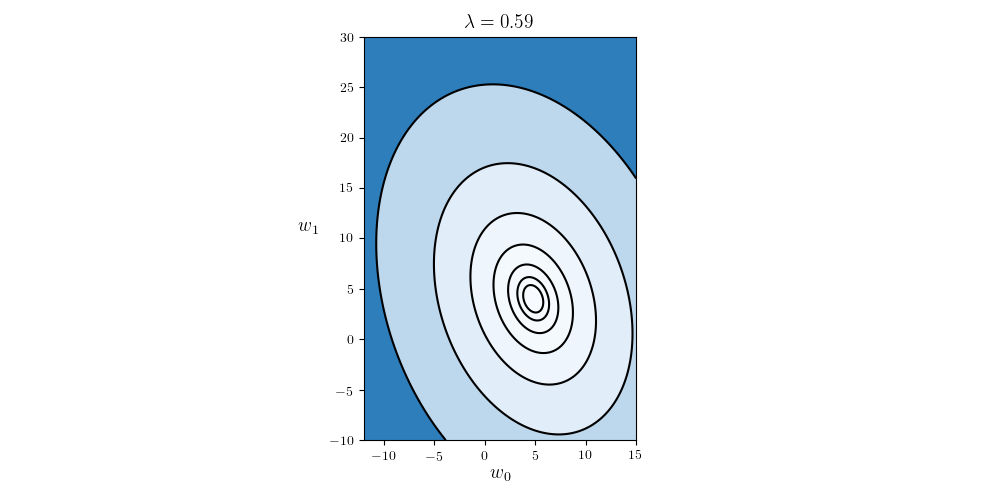
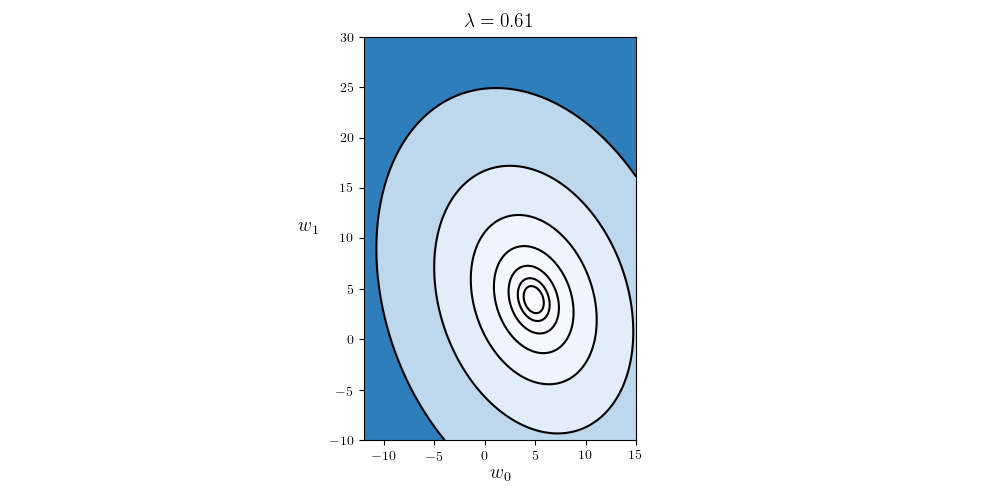
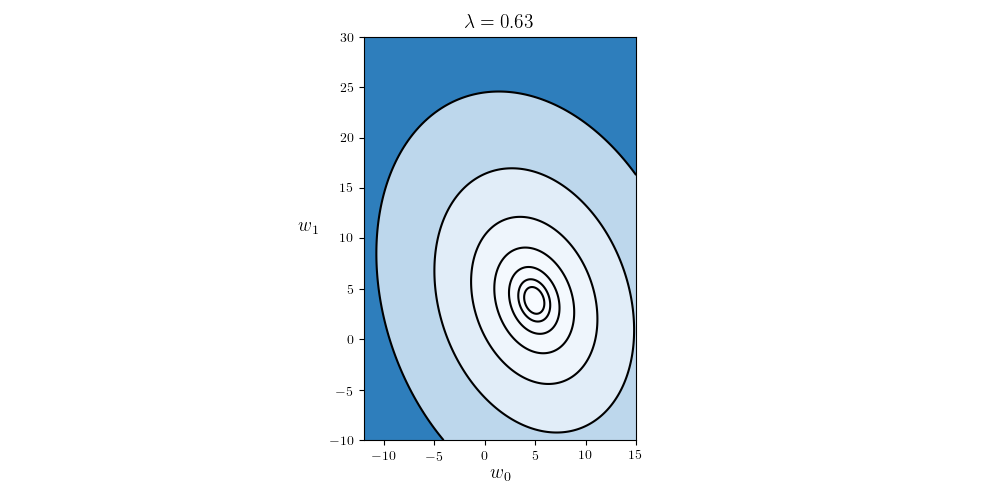
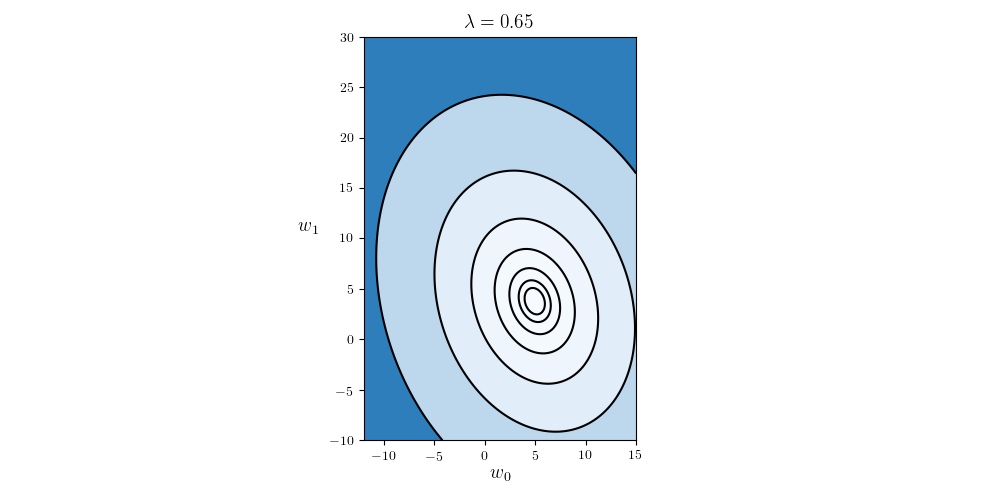
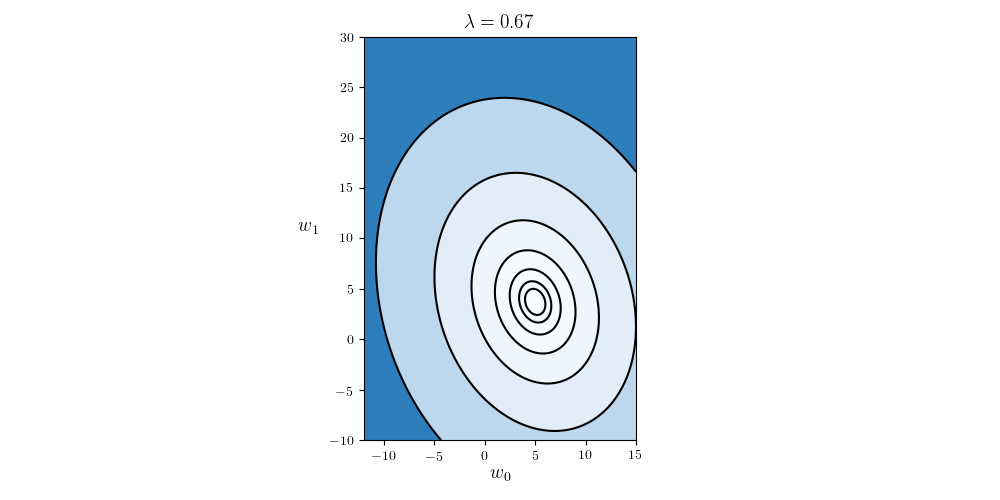
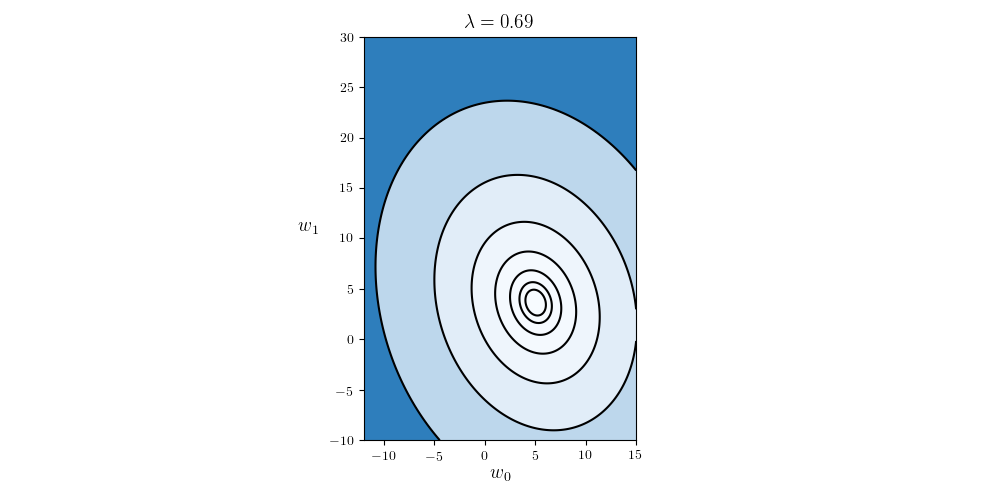
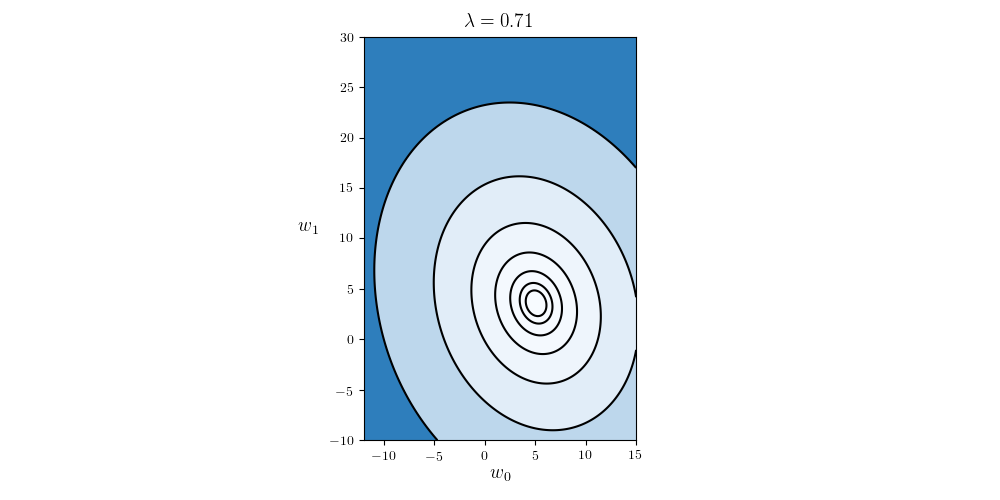
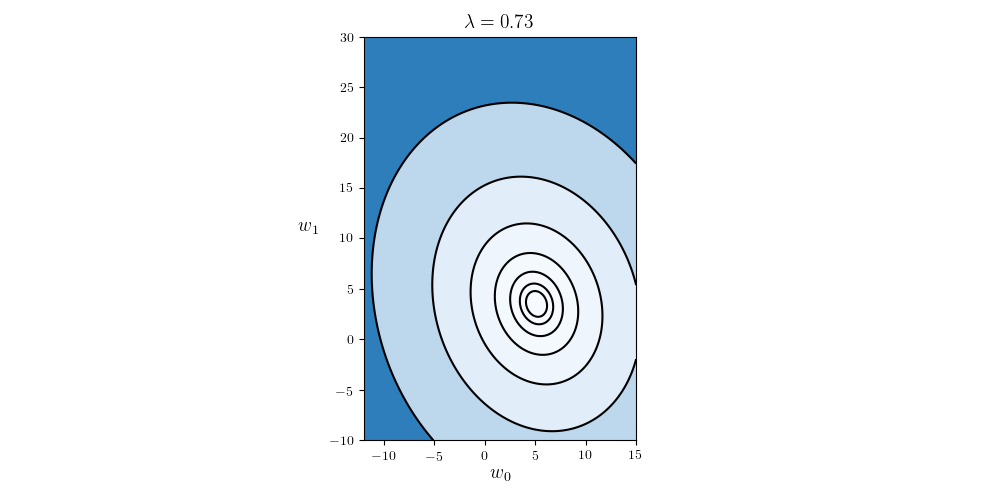
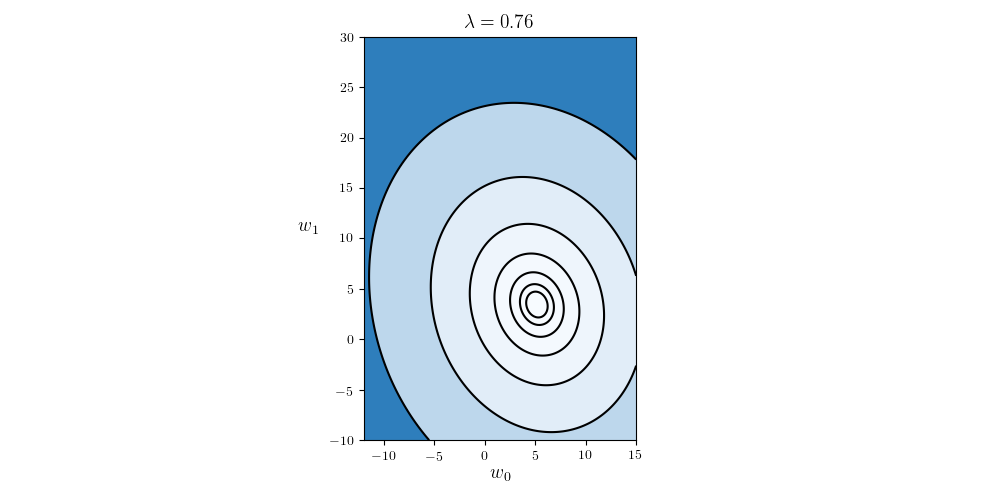
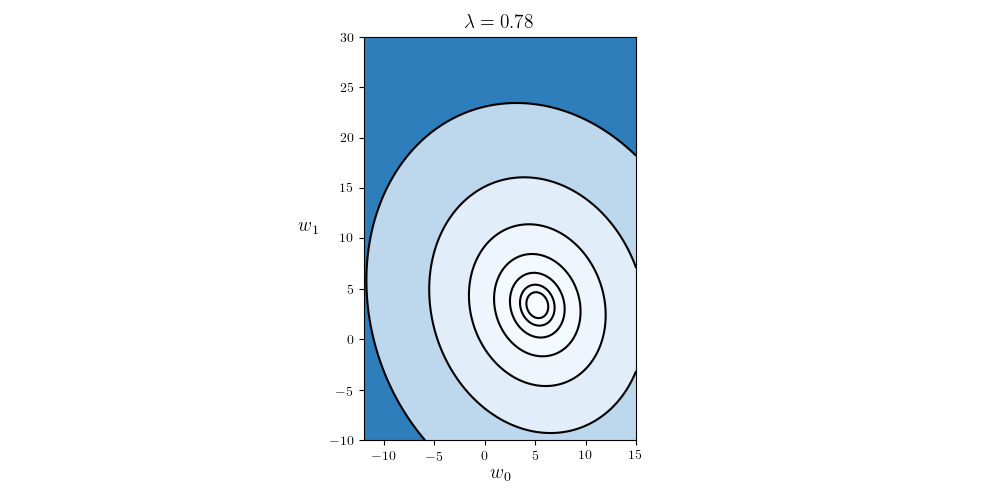
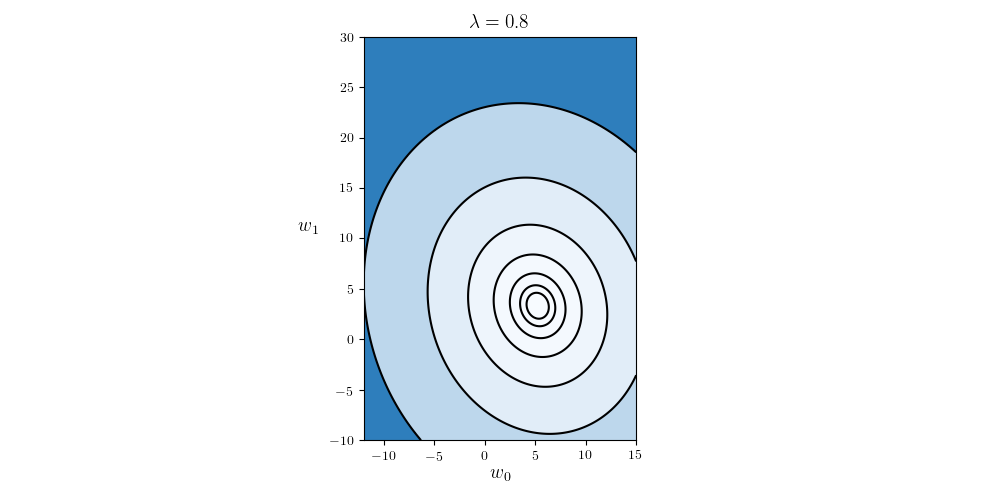
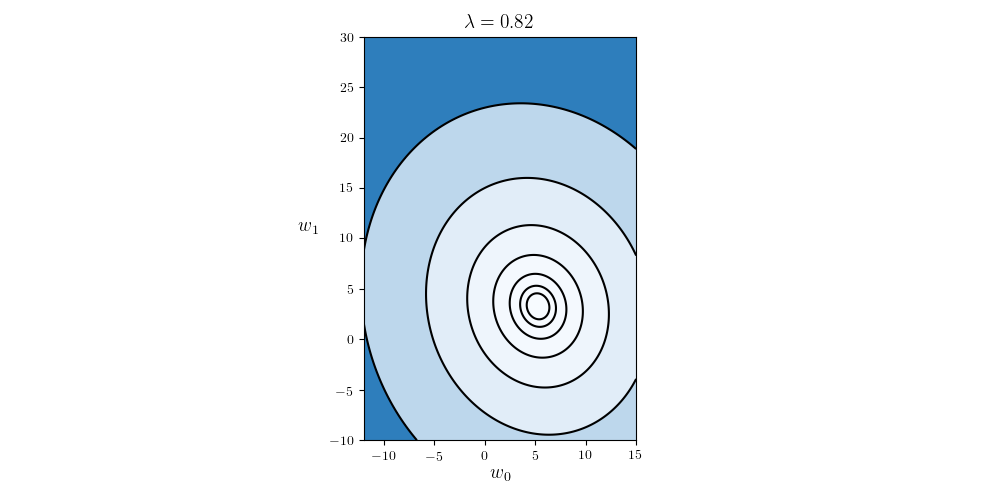
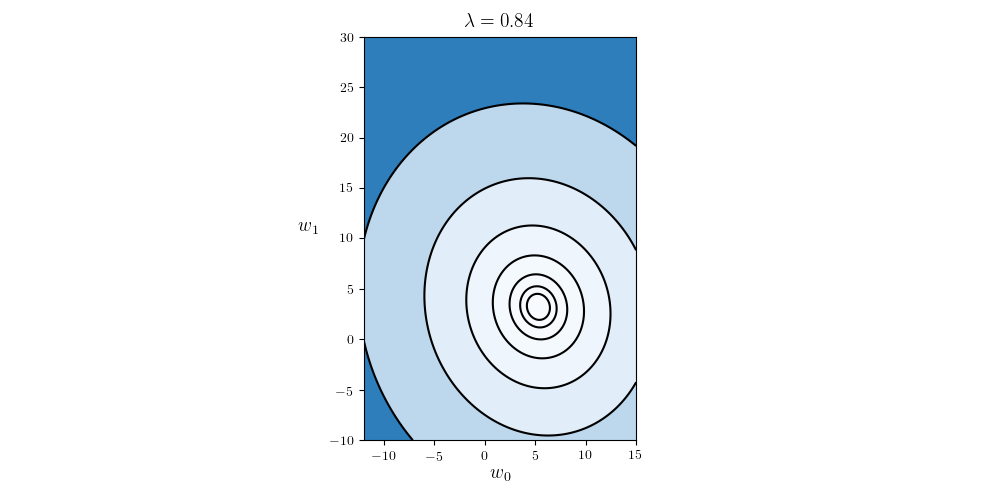
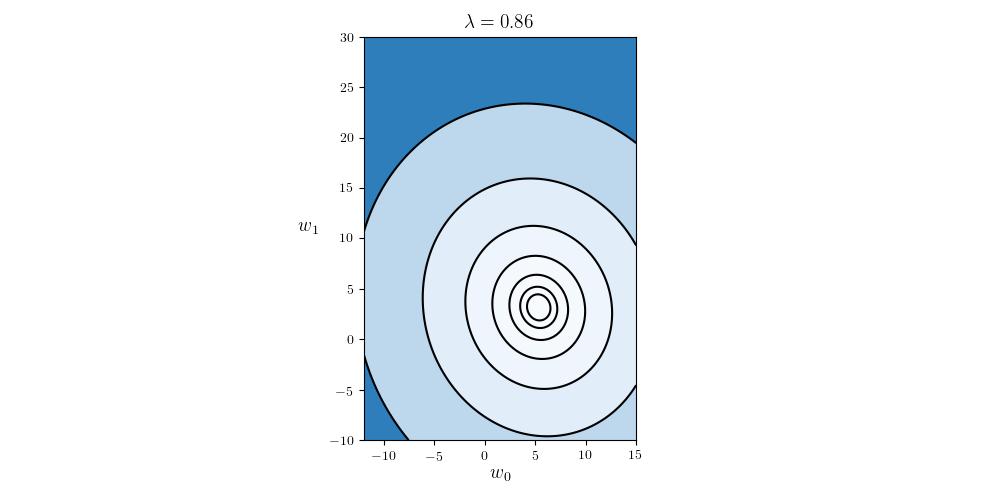
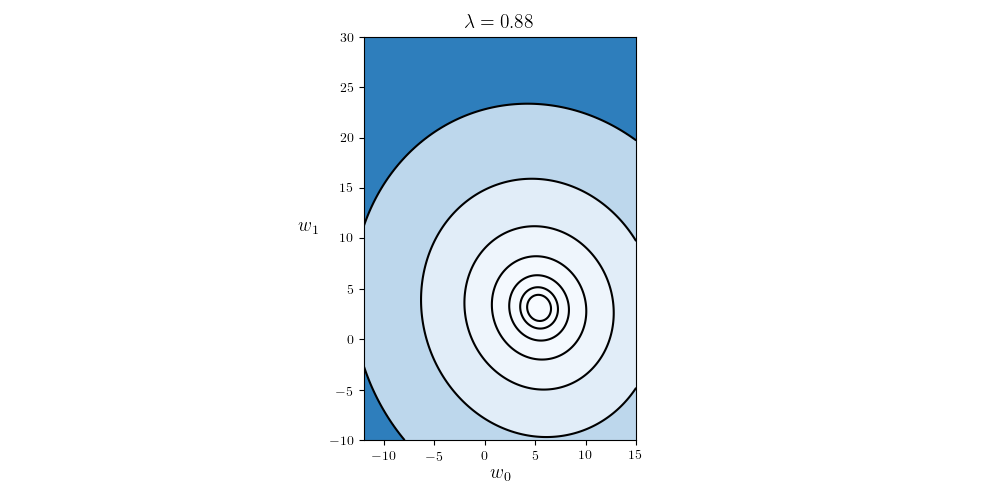
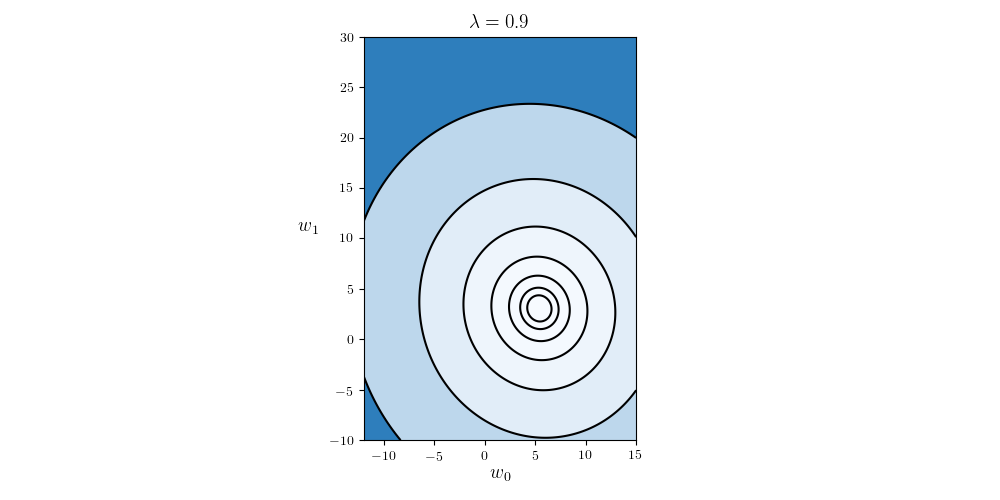
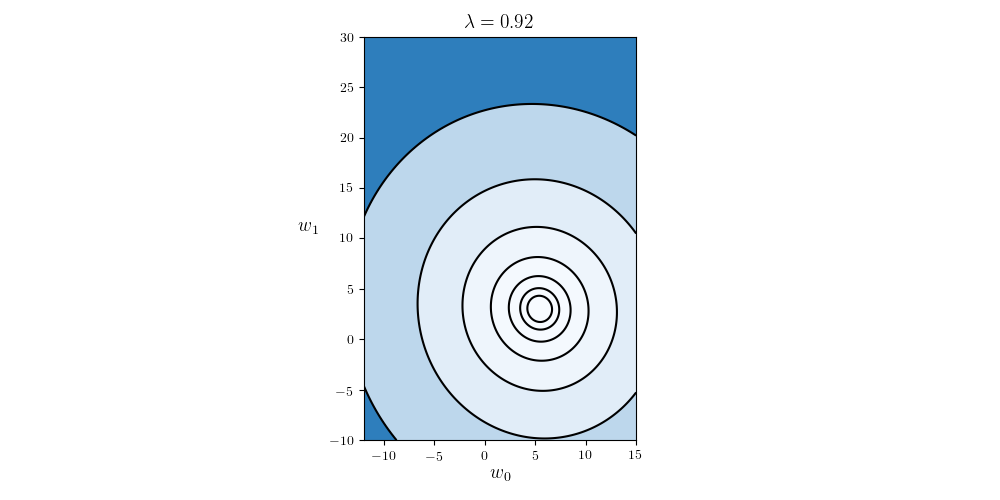
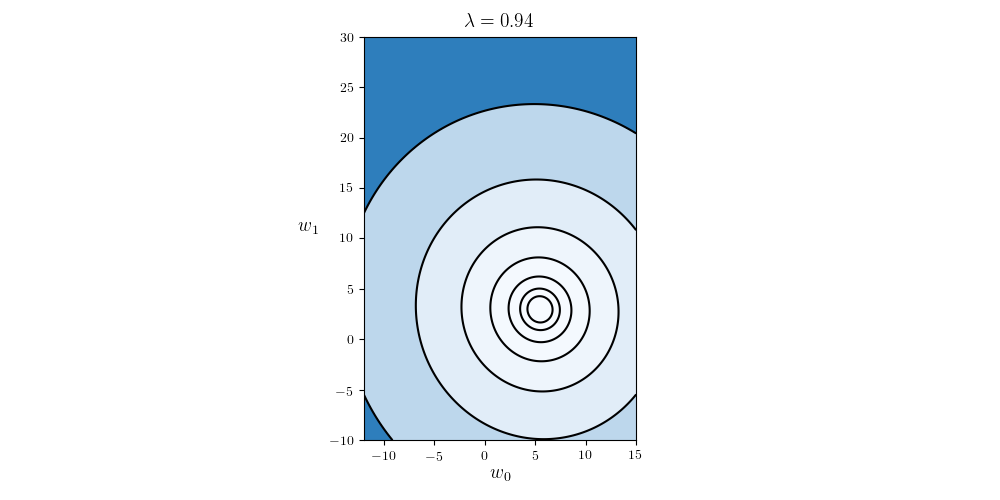
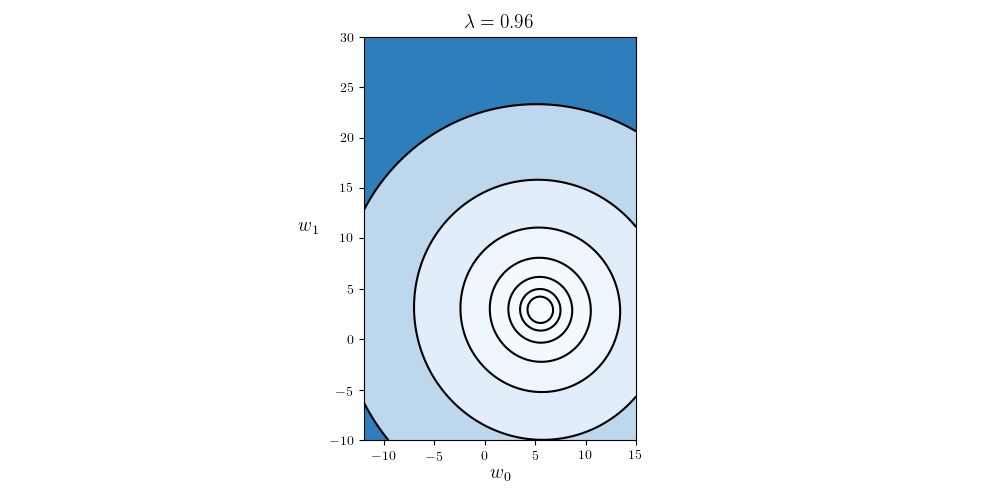
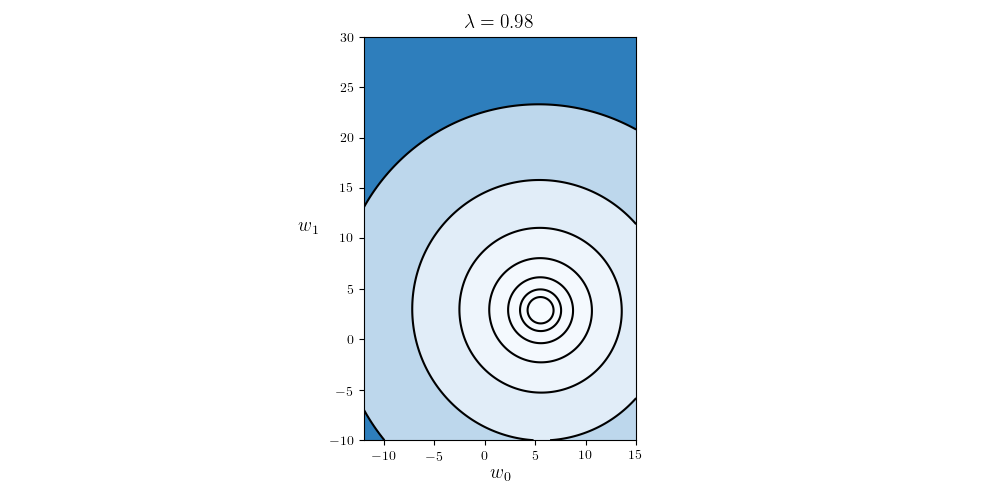
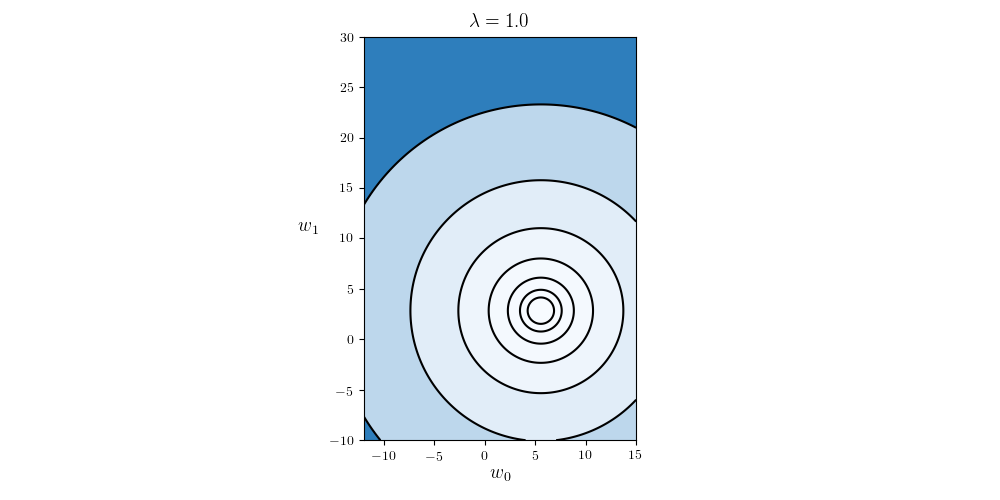

In [15]:
## This code cell will not be shown in the HTML version of this notebook
# animation showing cost function transformation from standard to normalized input
scaling_tool = feature_scaling_tools.Visualizer(x,x_normalized,y,'least_squares')
scaling_tool.animate_transition(num_frames=50,xmin = -12,xmax = 15,ymin = -10,ymax = 30,num_contours = 7)

In the next ``Python`` cell we repeat our previous run of unnormalized gradient descent - beginning at the same initial point $\mathbf{w}^0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$, using a steplength parameter $\alpha = 10^{-1}$ (the largest steplength value of the form $10^{-\gamma}$ we could find that caused the algorithm to converge).   However here we will only take $20$ steps instead of $100$ as we did before, since we basically reach the minimum after just a few steps now (no more long narrow valleys to struggle through!).

<IPython.core.display.Javascript object>


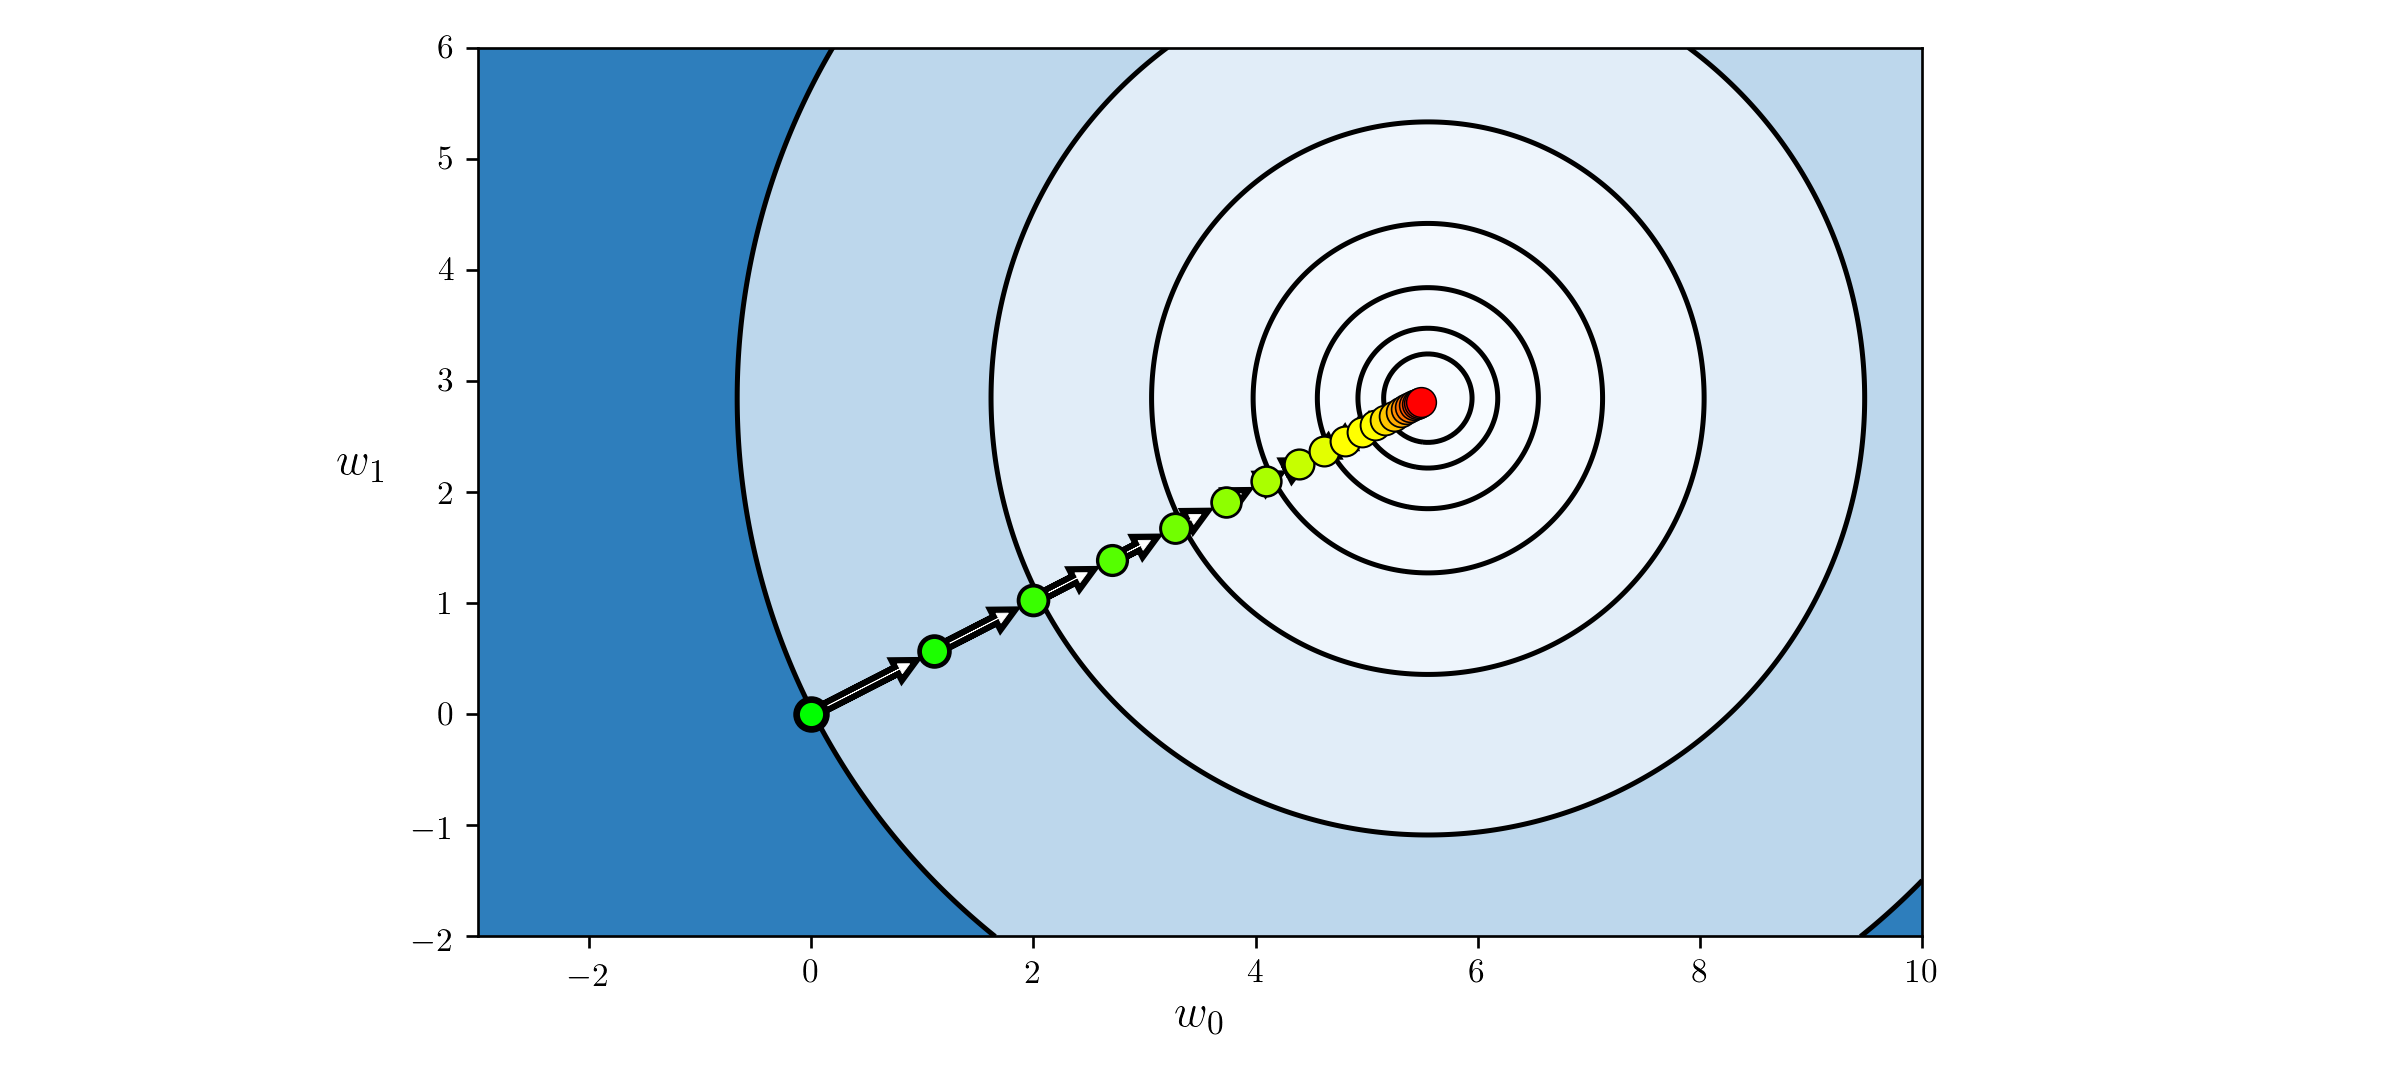

In [24]:
## This code cell will not be shown in the HTML version of this notebook
# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares_2; w = np.array([0.0,0.0])[:,np.newaxis]; max_its = 20; alpha_choice = 10**(-1);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# show run on contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -3,xmax = 10,ymin = -2,ymax = 6,num_contours = 7,show_original = False)

Using only a quarter of the number of descent steps - with precisely the same setup as previously - we get *much closer* to the cost function minimum!  

Let us plot the fit associated with the final set of weights (the final red point above) on our original dataset below.   Notice that in order to make this plot we must treat each new *input test point* on the linear predictor precisely as we treated our original input: i.e., we must subtract off the same mean and divide off the same standard deviation.  Thus with our fully tuned parameters $w_0^{\star}$ and $w_1^{\star}$ our linear predictor for any input point $x$ is, instead of $ w_0^{\star} + w_1^{\star}x^{\,}$, now

\begin{equation}
\text{normalized_predictor}\left(x\right) = w_0^{\star} + w_1^{\star}\left(\frac{x - \mu}{\sigma}\right).
\end{equation}

Again - since we normalized the input data we trained on, we must normalize any new input point we shove through our trained linear model.

The final predictor - plotted below in red - is far superior to the one we found previously, where we took $5$ times as many gradient descent steps, prior to normalizing the input data.  

<IPython.core.display.Javascript object>


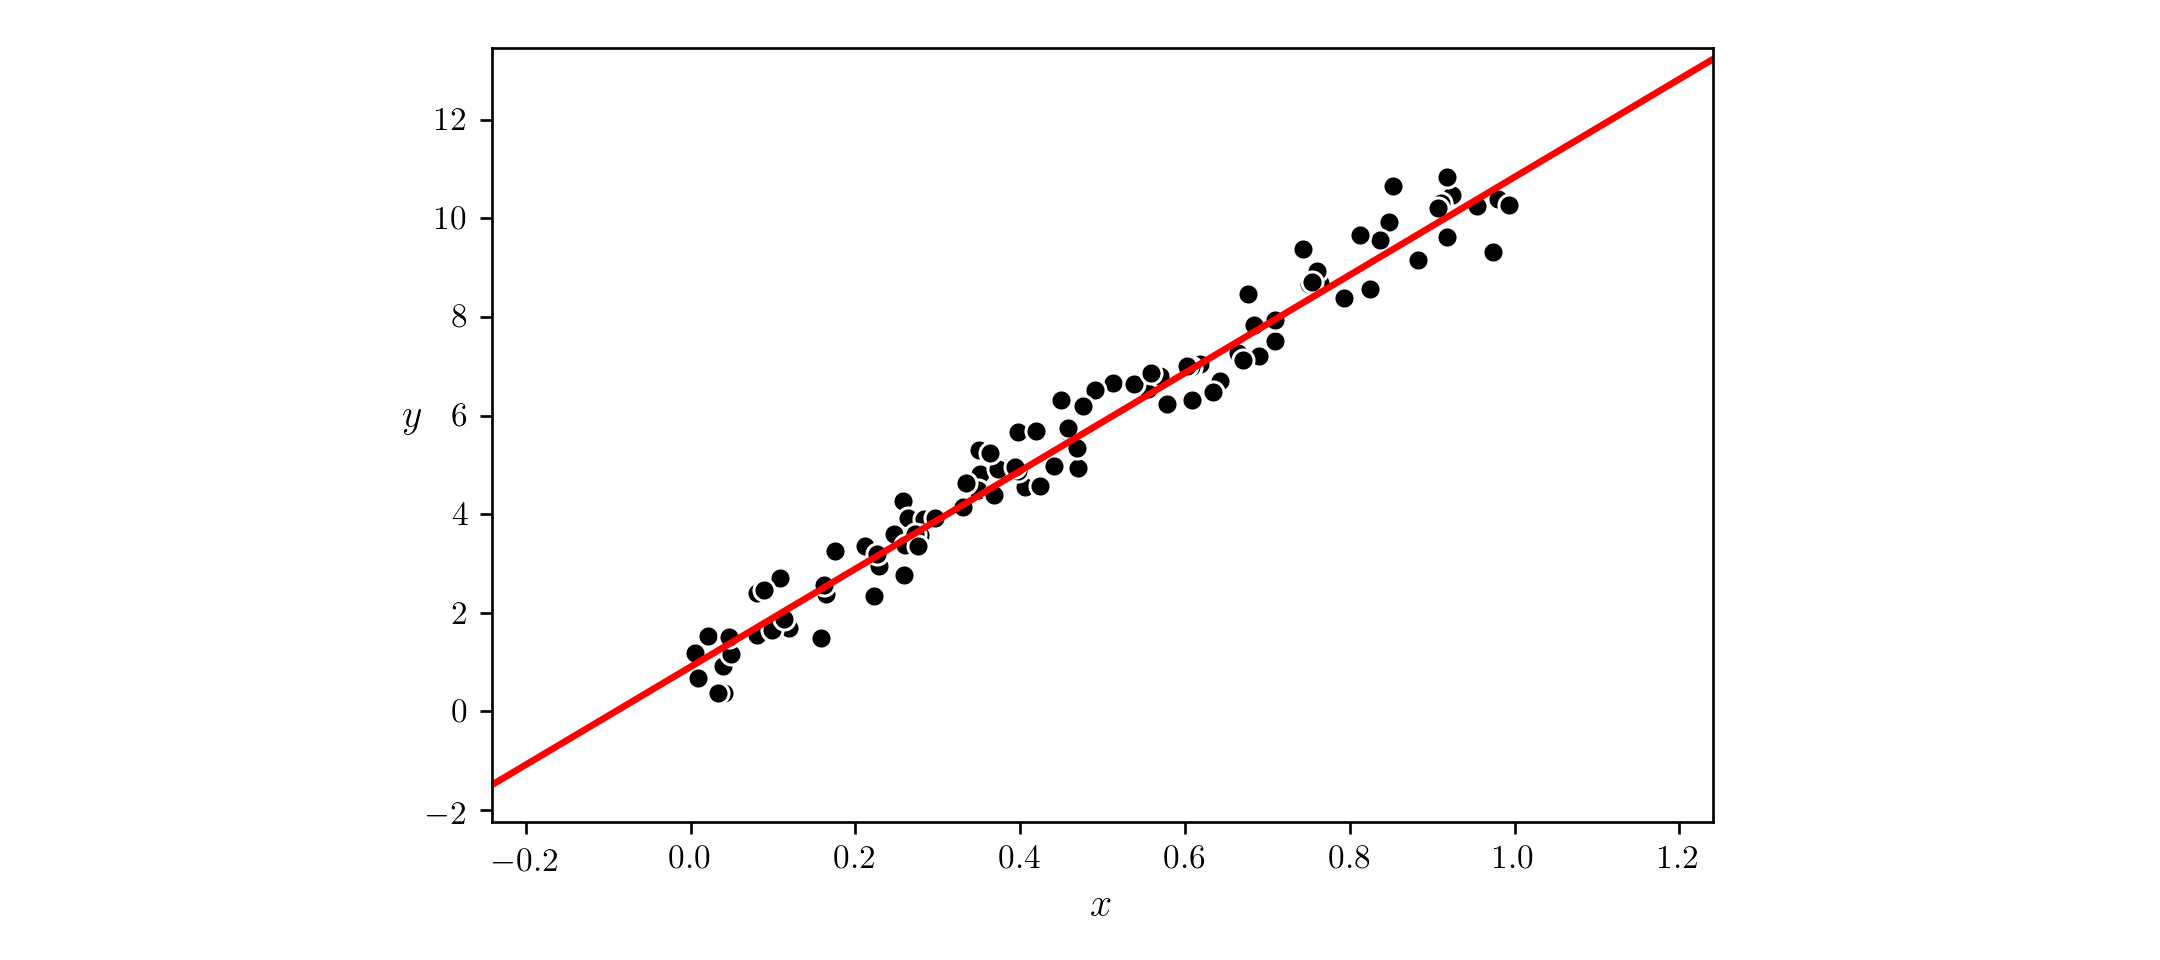

In [25]:
## This code cell will not be shown in the HTML version of this notebook
# the original data and best fit line learned from our gradient descent run
ind = np.argmin(cost_history)
least_weights = weight_history[ind]
demo.plot_fit(plotting_weights = [least_weights],colors = ['r'],transformer = normalizer)

#### <span style="color:#a50e3e;"> Example 1. </span>  Normalizing the input of a student debt dataset

In the example we compare the performance of gradient descent in tuning the Least Squares cost function on the United States student debt dataset -  loaded in and plotted below - when using the raw dataset versus when the input is normalized.  Here the input is in increments of time, and the output is the corresponding total amount of student debt held in the United States.

<IPython.core.display.Javascript object>


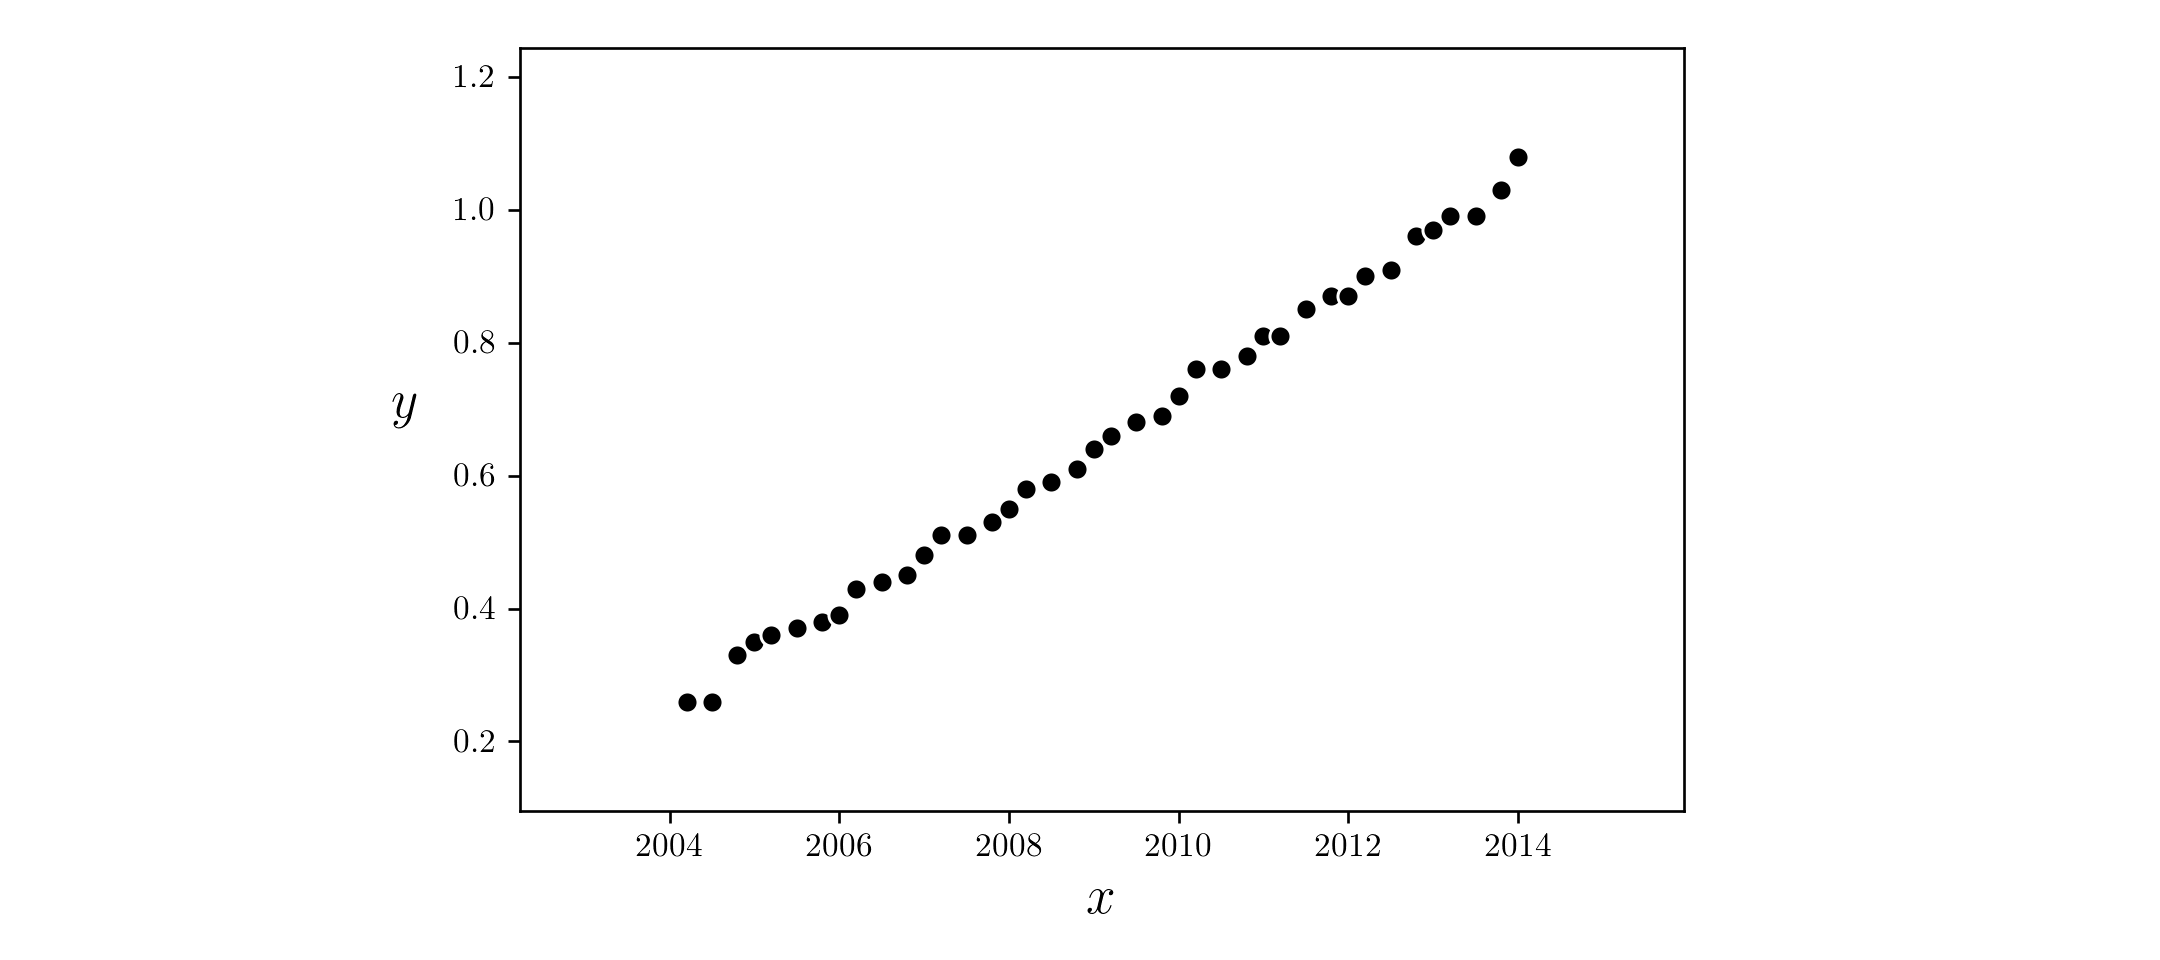

In [27]:
## This code cell will not be shown in the HTML version of this notebook
# load data
data = np.loadtxt(datapath + 'student_debt.csv',delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

Below we run gradient descent for $25$ iterations using the steplength parameter $\alpha = 10^{-7}$ - the largest steplength value $\alpha$ of the form $10^{-\gamma}$ (where $\gamma$ is a positive integer) that produced convergence.  We also used the initial point $\mathbf{w}^0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$.  After running the algorithm we plot the contours of the Least Squares cost function with the steps from our gradient descent run plotted on top.

Here we can see that the contours of the cost function are enormously elliptical - so much so that the cost function no longer looks like a quadratic (even though it still is - as is every Least Squares cost function, as discussed in Section 8.2).  Because of this there is essentially no practical way to tune the Least Squares cost function on this dataset using gradient descent - unless of course we normalize the input.

<IPython.core.display.Javascript object>


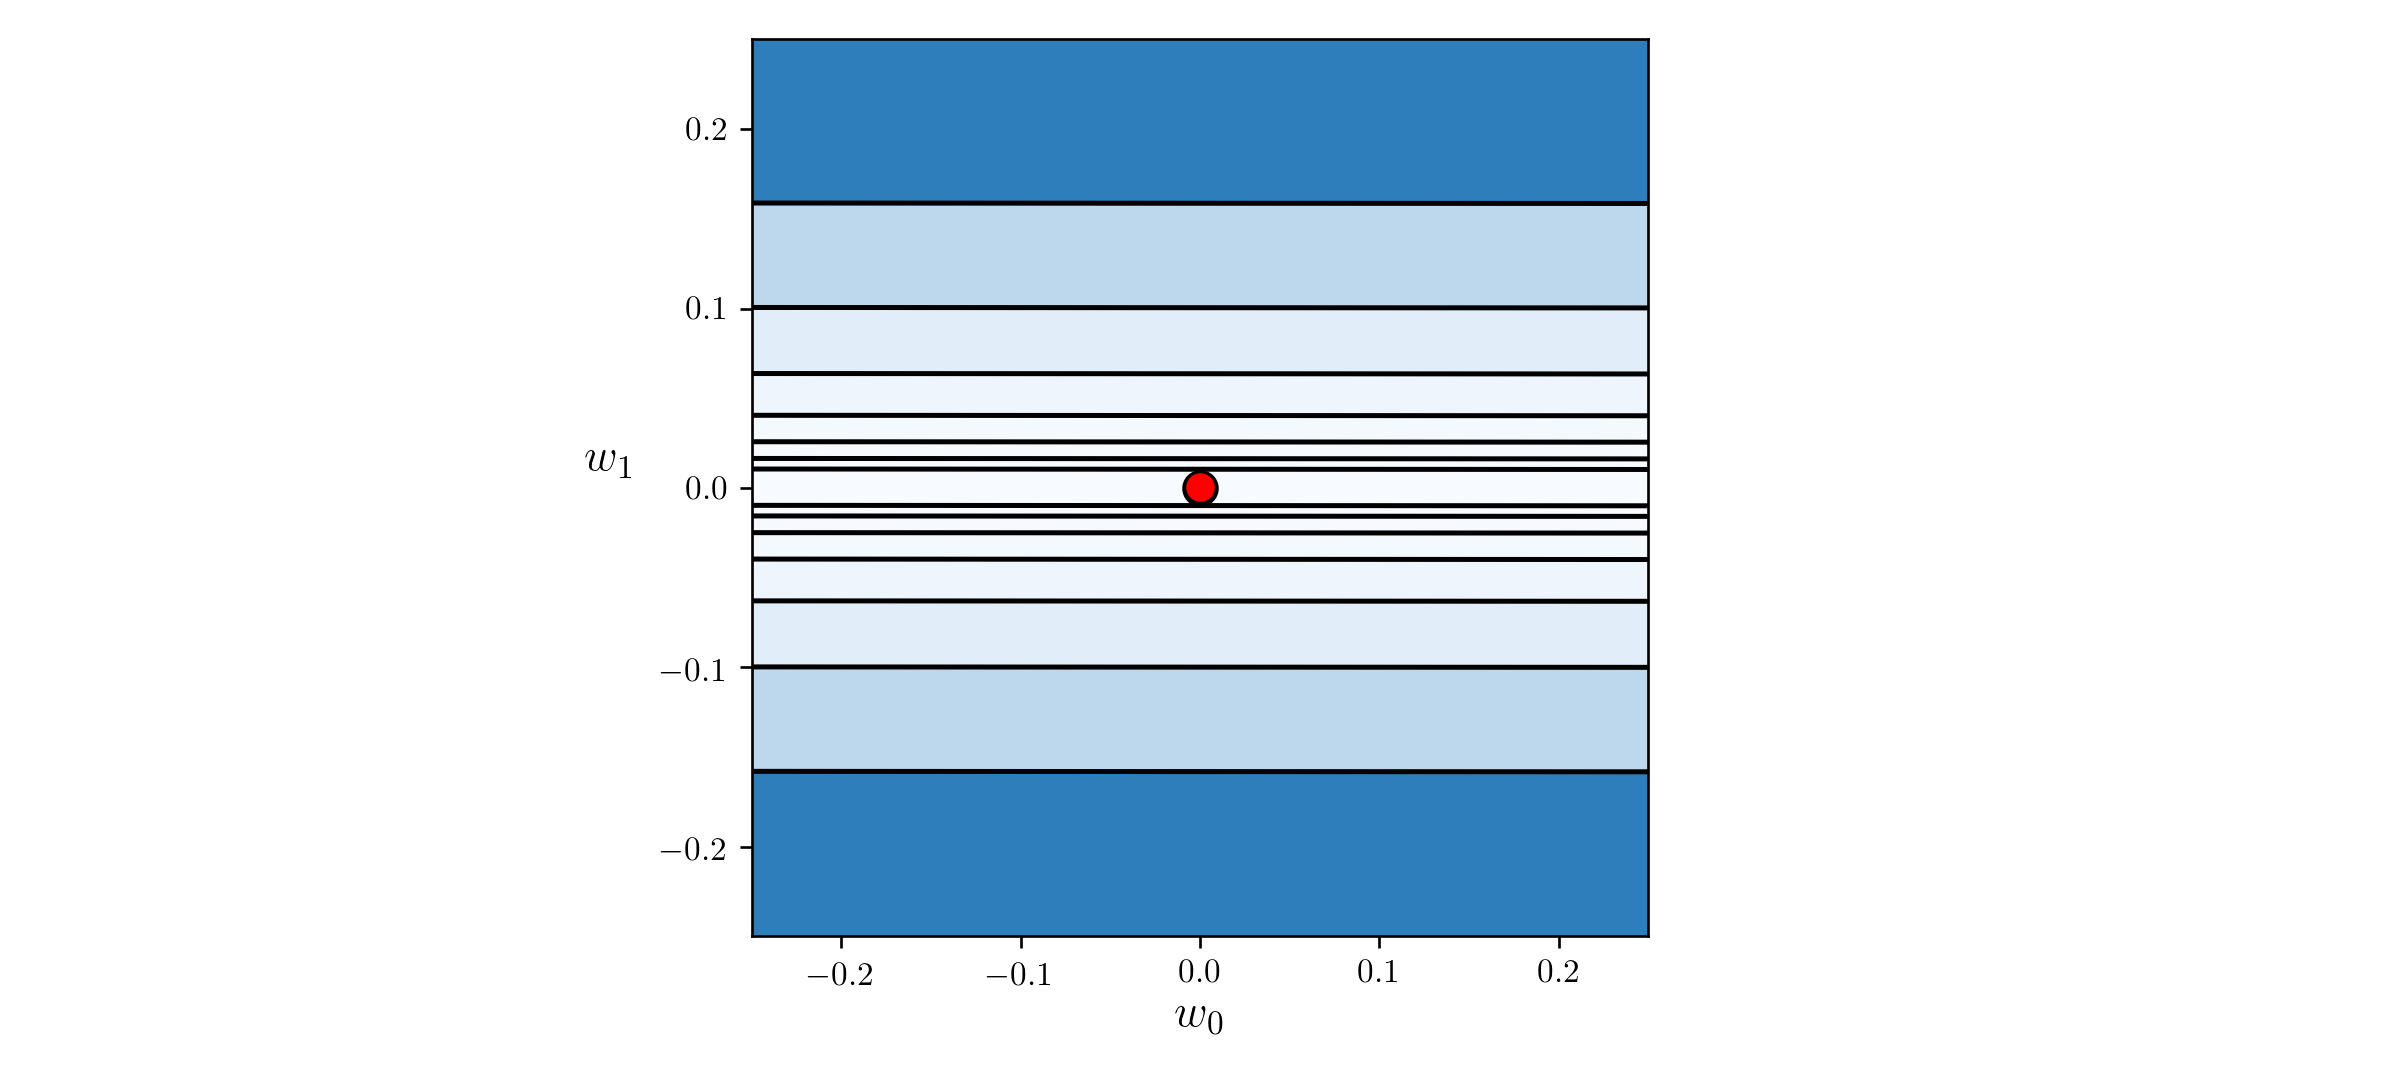

In [30]:
## This code cell will not be shown in the HTML version of this notebook
# an implementation of the least squares cost function for linear regression, precisely
# what was shown in Section 8.1 but here pulled in from a backend file
least_squares = cost_lib.choose_cost(x,y,'least_squares')

# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; w = np.array([0.0,0.0])[:,np.newaxis]; max_its = 25; alpha_choice = 10**(-7);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# show run on contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -0.25,xmax = 0.25,ymin = -0.25,ymax = 0.25,num_contours = 7,show_original = False)

<IPython.core.display.Javascript object>


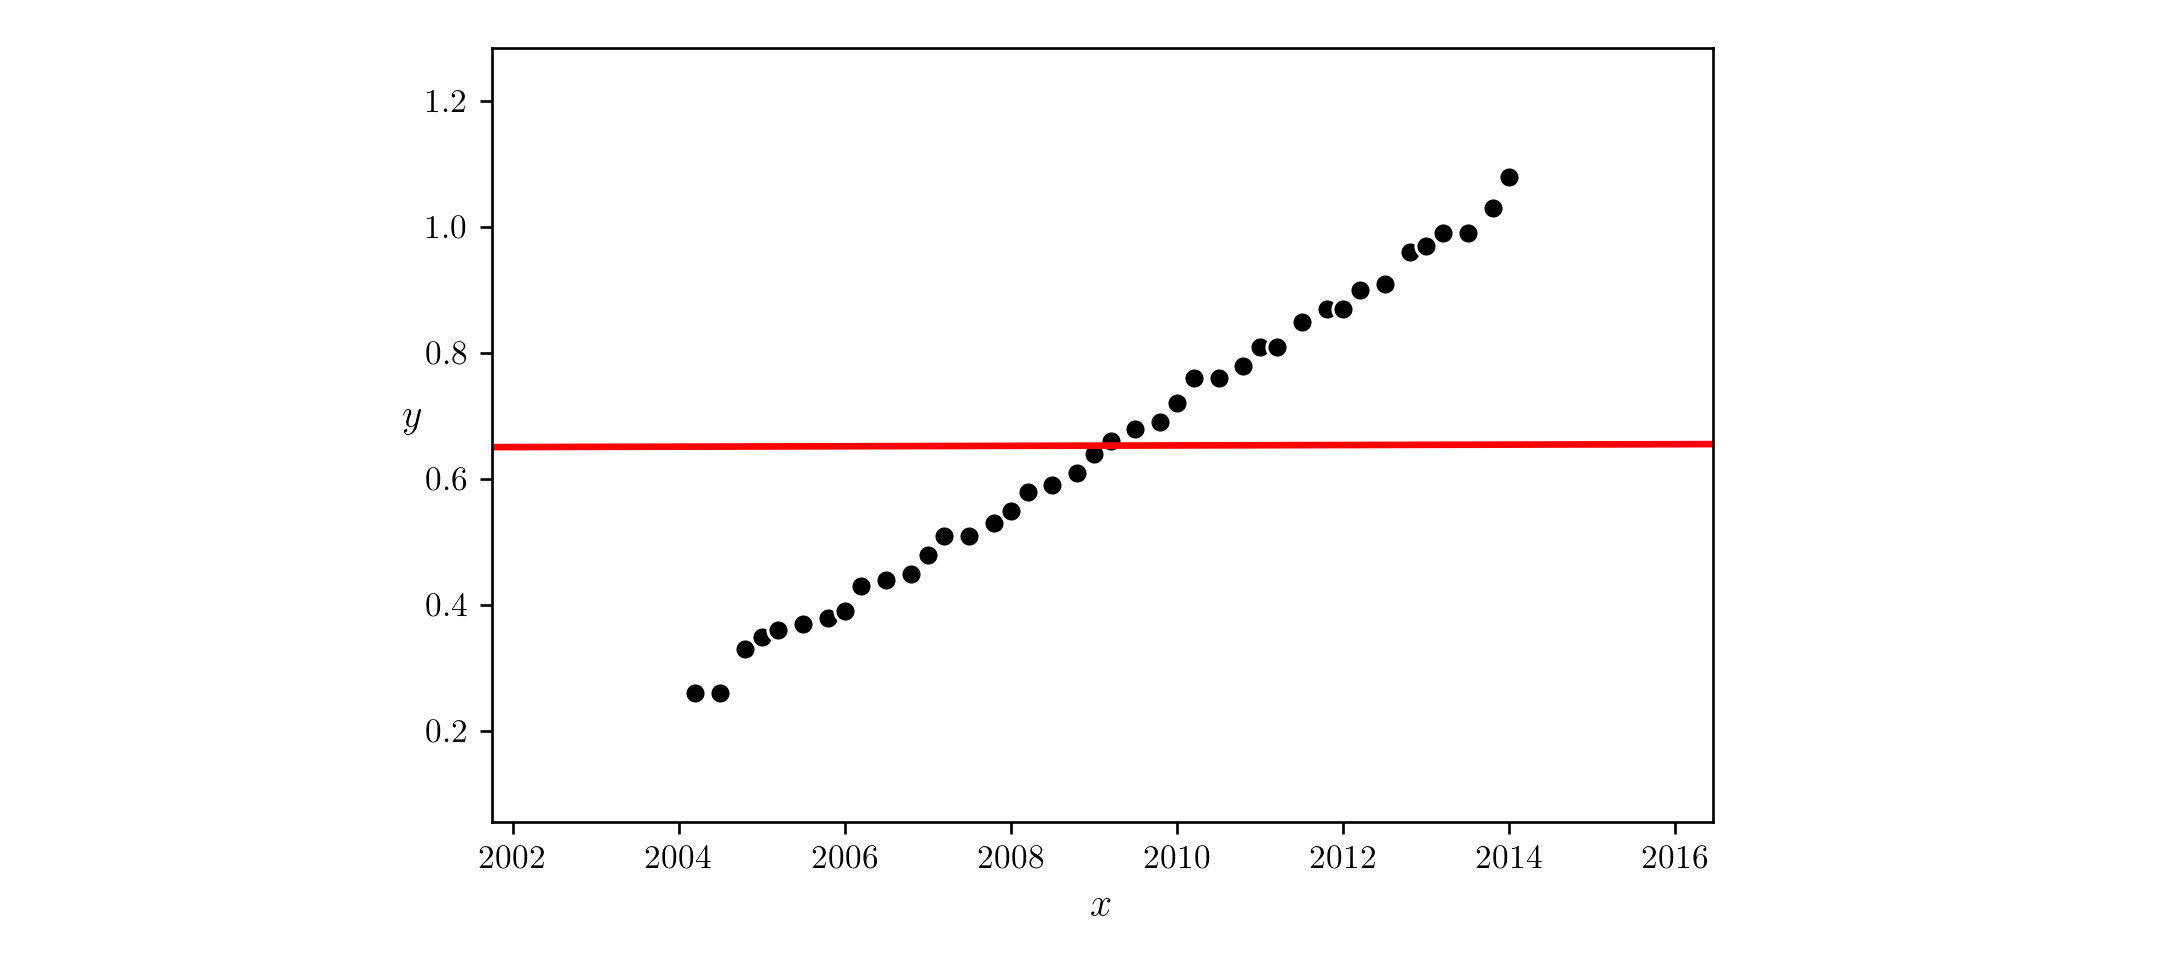

In [31]:
## This code cell will not be shown in the HTML version of this notebook
# the original data and best fit line learned from our gradient descent run
ind = np.argmin(cost_history)
least_weights = weight_history[ind]
demo.plot_fit(plotting_weights = [least_weights],colors = ['r'])

We now normalize the input of this dataset and re-run gradient descent at the same initial point.

<IPython.core.display.Javascript object>


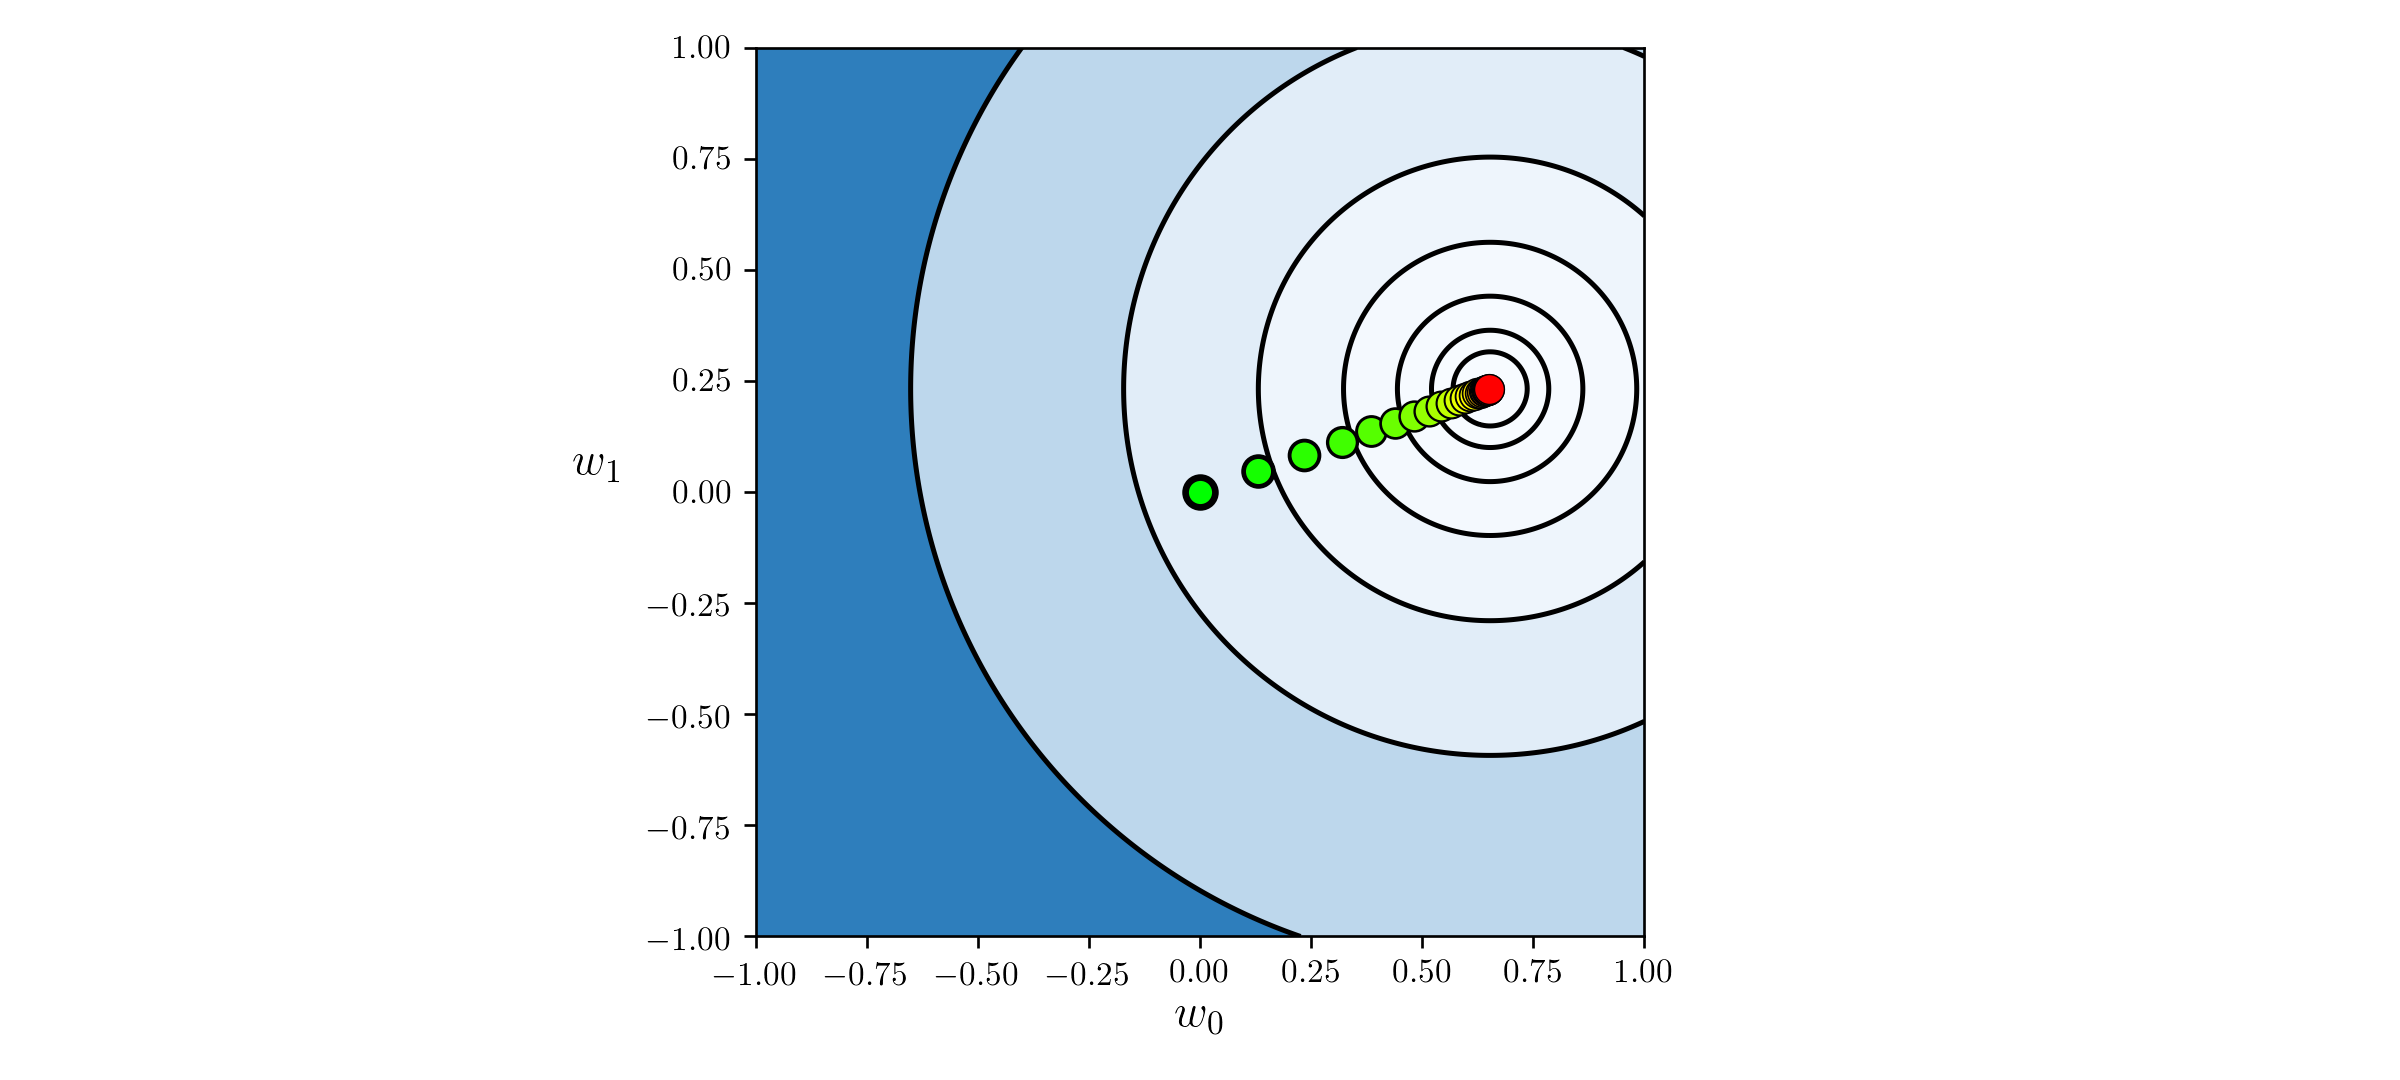

In [35]:
## This code cell will not be shown in the HTML version of this notebook
# create normalizer based on input
normalizer,inverse_normalizer = standard_normalizer(x)

# normalize input by subtracting off mean and dividing by standard deviation
x_normalized = normalizer(x)

# an implementation of the least squares cost function for linear regression, precisely
# what was shown in Section 8.1 but here pulled in from a backend file
least_squares_2 = cost_lib.choose_cost(x_normalized,y,'least_squares')

# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares_2; w = np.array([0.0,0.0])[:,np.newaxis]; max_its = 25; alpha_choice = 10**(-1);
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# show run on contour plot
static_plotter.two_input_contour_plot(g,weight_history,xmin = -1,xmax = 1,ymin = -1,ymax = 1,num_contours = 7,show_original = False,arrows = False)

The corresponding fit line - again where we normalize each new testing input as $\text{normalized_predictor}\left(x\right) = w_0^{\star} + w_1^{\star}\left(\frac{x - \mu}{\sigma}\right)$ - is significantly higher quality than the unnormalized result.

<IPython.core.display.Javascript object>


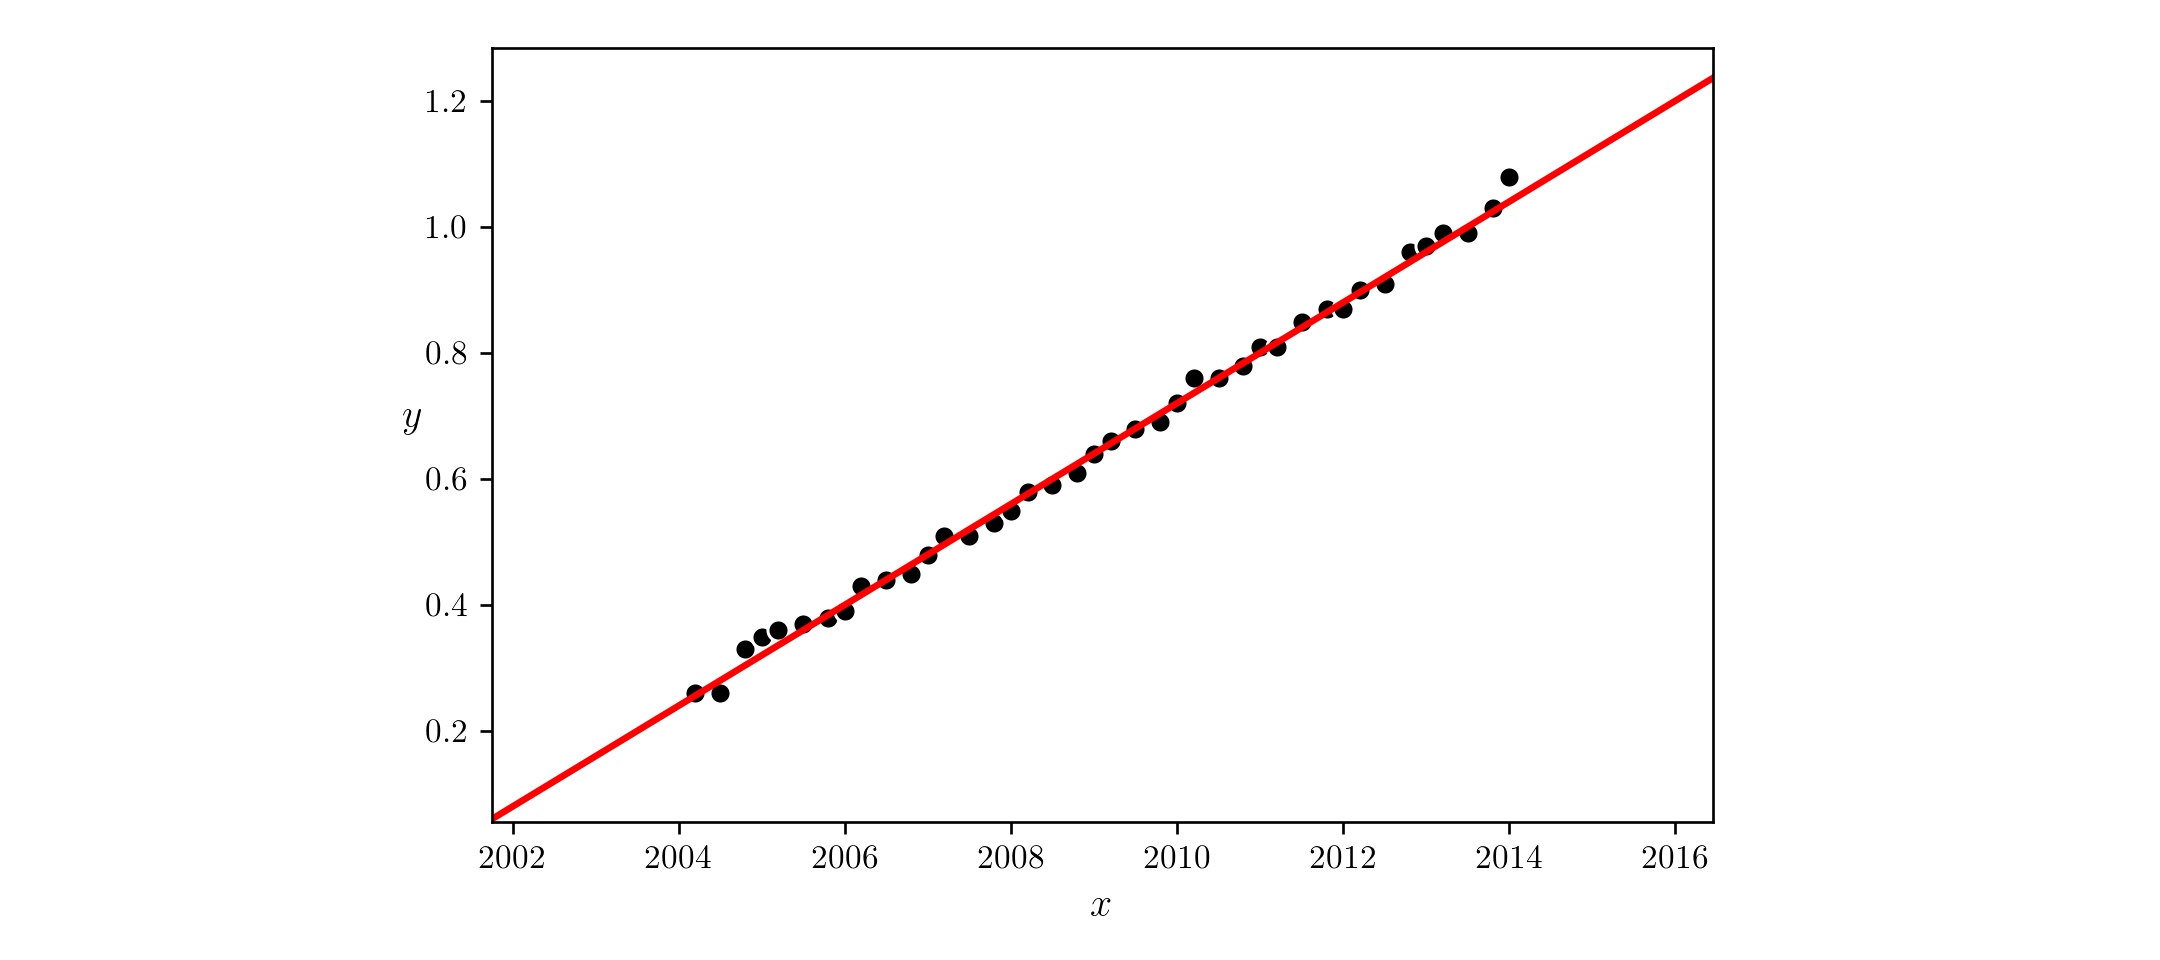

In [36]:
## This code cell will not be shown in the HTML version of this notebook
# the original data and best fit line learned from our gradient descent run
ind = np.argmin(cost_history)
least_weights = weight_history[ind]
demo.plot_fit(plotting_weights = [least_weights],colors = ['r'],transformer = normalizer)

## 8.4.2 Feature scaling for multi-input datasets

Now that we have seen empirical evidence that the standard normalization scheme significantly aids with parameter tuning with single-input linear regression, we explore (by example) how the same normalization scheme likewise helps significantly with the  multi-input datasets as well.  In the subsections that follow this one we summarize our findings, and provide more rigorous (mathematical) evidence to backup these experimental findings.  In particular we will use the $N = 5$ input dimension regression dataset loaded in the below.  This dataset consists of a selection of random points taken from a random hyperplane in six dimensions (five inputs, one output), with absolutely no noise whatsoever added to the output. 

Lets examine the numerical range of each input dimension / feature.  In the next cell we plot a discrete histogram of each input feature.  

<IPython.core.display.Javascript object>


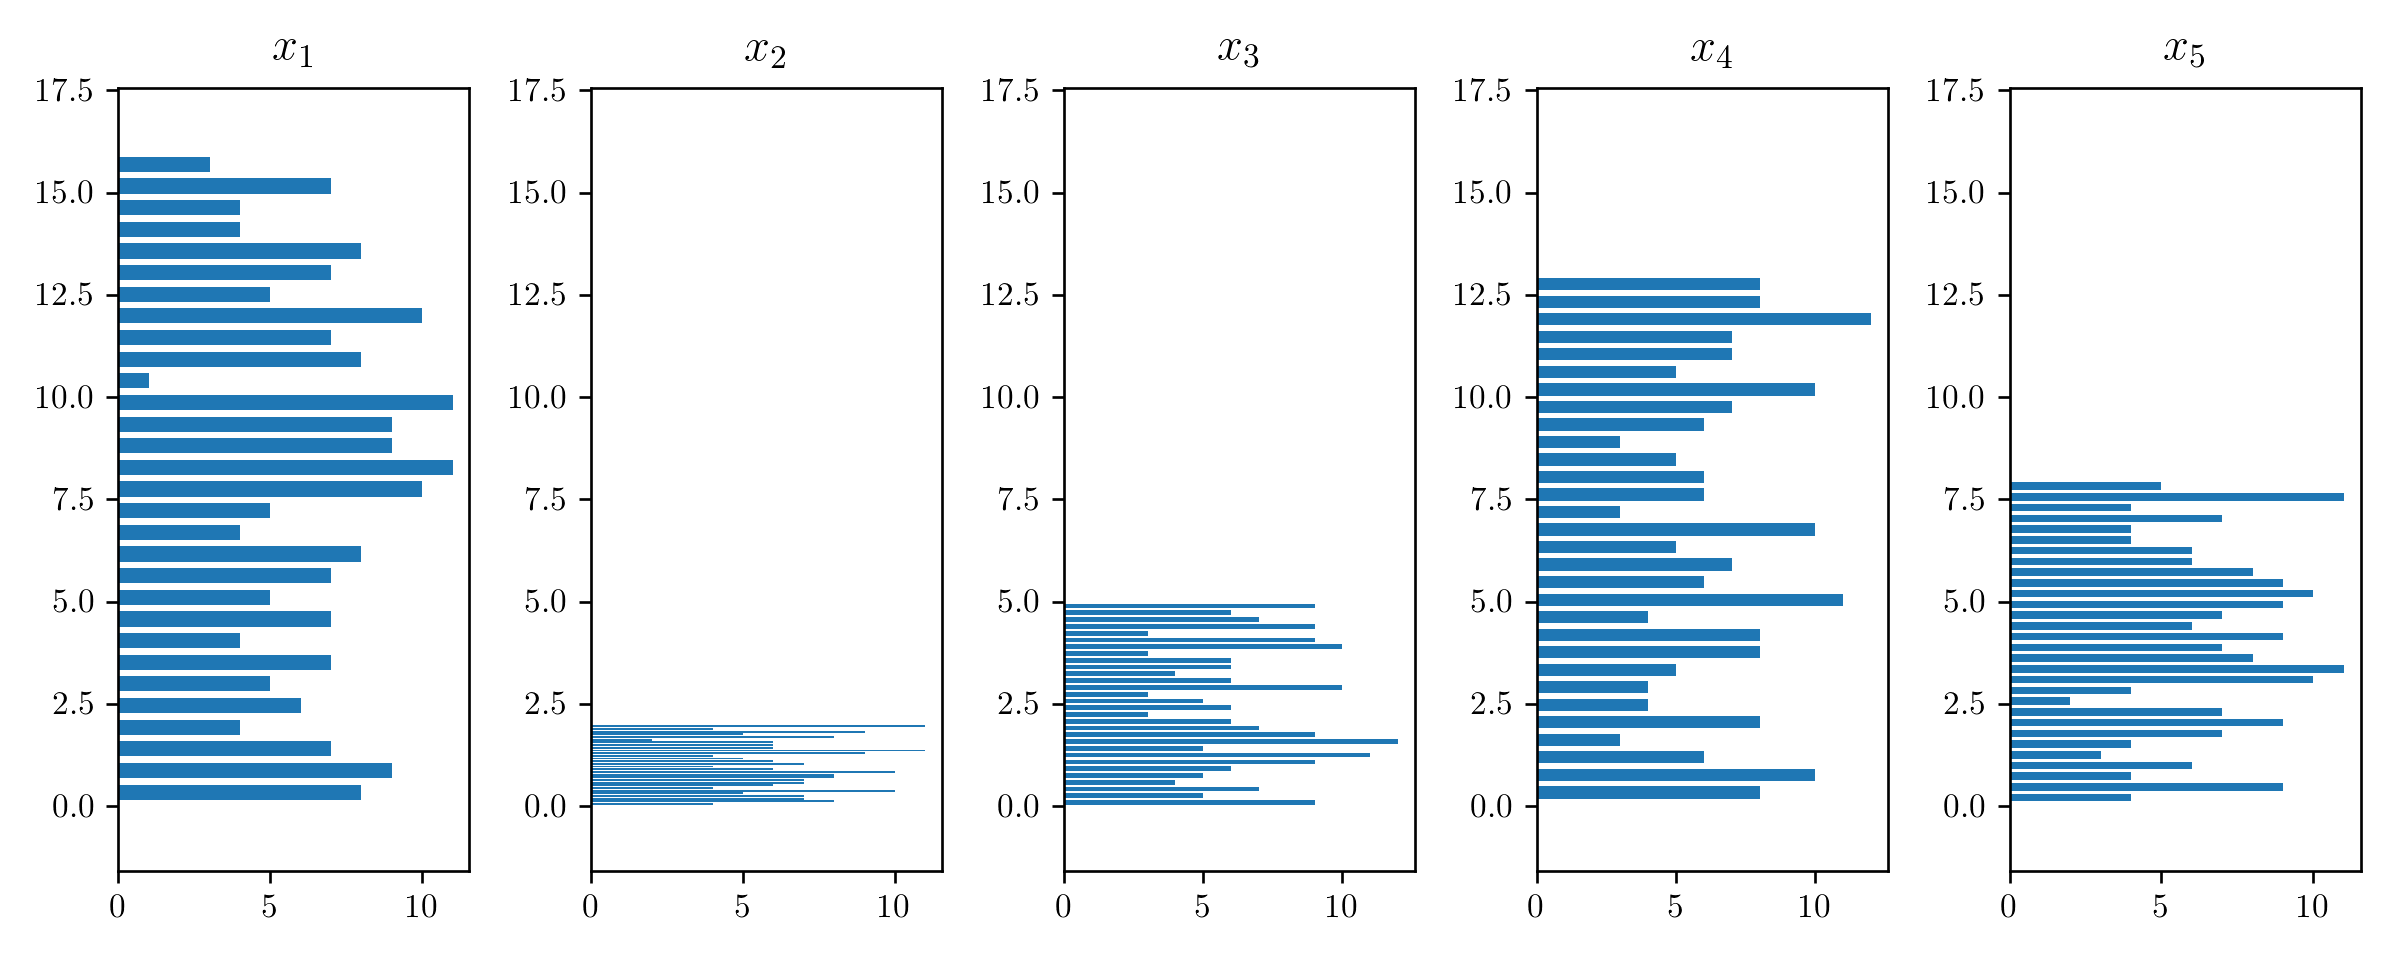

In [39]:
## This code cell will not be shown in the HTML version of this notebook
# load data
data = np.loadtxt(datapath + 'highdim_multirange_linregress.csv',delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# plot the distribution of each input feature
scaling_tool = feature_scaling_tools.Visualizer([],[],[],[])
scaling_tool.feature_distributions(x)

As we can see in the plot above, the distributions of our input features here are way out of scale with each other, so we can expect gradient descent to converge quite slowly here - unless we normalize each input feature to have a similar distribution.

In analogy to the single-input case, here we should normalize *each feature individually* - that is each coordinate direction $x_n$.  What are we trying to avoid by doing this?  The (common) scenario where the distribution of input along each individual input dimensions widely varies, since this leads to a cost function with long narrow valley(s) that substantially slows down gradient descent.

Thus with the aim of standardizing each input direction - also referred to as a *feature* - we should normalize the $n^{th}$ input dimension of an $N$-input dimensional dataset $\left\{\mathbf{x}_p,y_p\right\}_{p=1}^N$ as 

\begin{equation}
x_{p,n} \longleftarrow \frac{x_{p,n} - \mu_n}{\sigma_n}
\end{equation}

where $x_{p,n}$ is the $n^{th}$ coordinate of point $\mathbf{x}_p$ and $\mu_n$ and $\sigma_n$ are the mean and standard deviation of the $n^{th}$ dimension of the data, respectively, and are defined as 

\begin{array}
\
\mu_n = \frac{1}{P}\sum_{p=1}^{P}x_{p,n} \\
\sigma_n = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_{p,n} - \mu_n \right)^2}
\end{array}

We could loop over each dimension and compute these values, or just use ``Numpy``'s built in broadcasting to compute them all simultaneously as shown in the next cell.

Now lets look at the distribution of our normalized input features.  

<IPython.core.display.Javascript object>


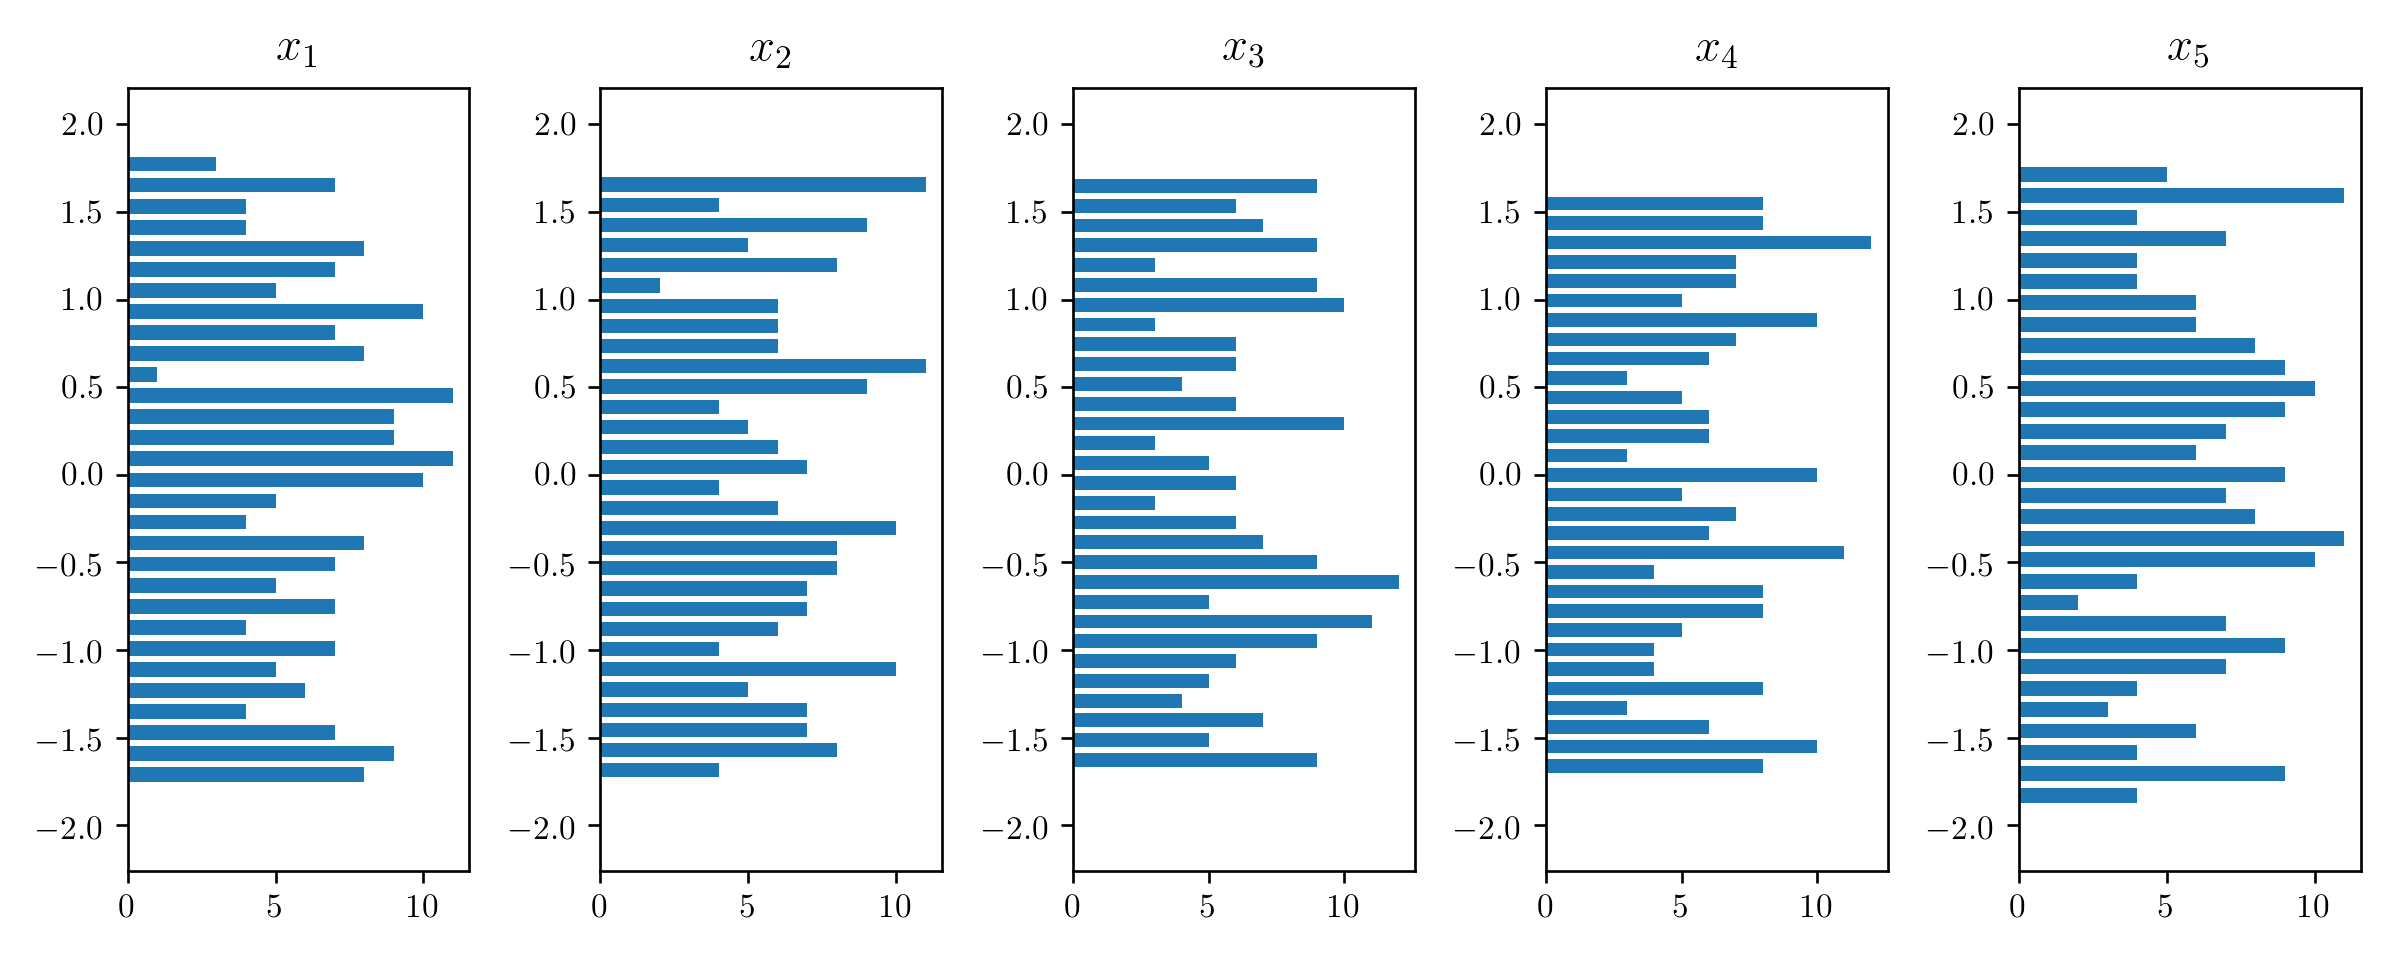

In [41]:
## This code cell will not be shown in the HTML version of this notebook
# create normalizer based on input
normalizer,inverse_normalizer = standard_normalizer(x)

# normalize input by subtracting off mean and dividing by standard deviation
x_normalized = normalizer(x)

# plot the distribution of each input feature
scaling_tool.feature_distributions(x_normalized)

Much better!  With each input distribution normalized and roughly looking the same we can intuit, no individual weight $w_n$ will be significantly more sensitive (to proper tuning) than the others, and we can expect gradient descent to have a much easier time here.

Lets make a similar run of gradient descent using both the original and normalized data, comparing the results in terms of the cost function history plots.  Here we use the same initial point, and the smallest fixed steplength parameter in each instance of the form $10^{-\gamma}$ for nonnegative $\gamma$ that produced convergence.

<IPython.core.display.Javascript object>


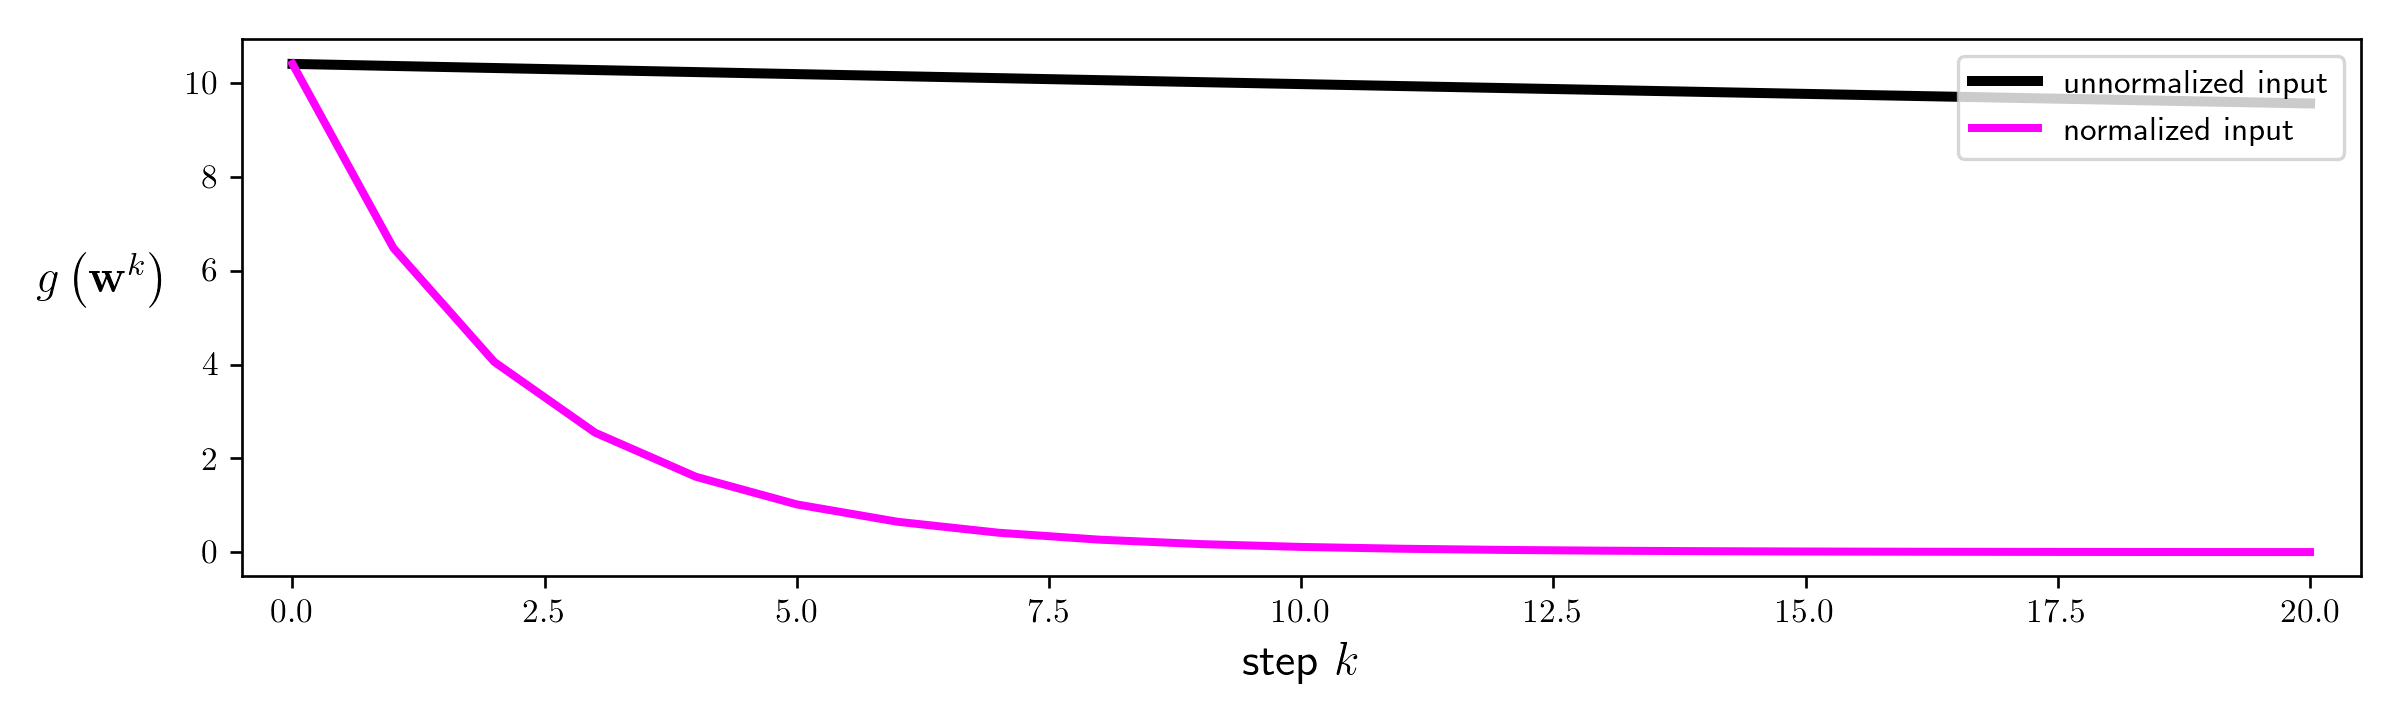

In [43]:
## This code cell will not be shown in the HTML version of this notebook
### least squares functions for both our original and normalized data
least_squares = cost_lib.choose_cost(x,y,'least_squares')
least_squares_2 = cost_lib.choose_cost(x_normalized,y,'least_squares')

### run gradient descent for each input
g = least_squares; w = np.zeros((6,1)); max_its = 20; alpha_choice = 10**(-3);
weight_history_1,cost_history_1 = optimizers.gradient_descent(g,alpha_choice,max_its,w)

g = least_squares_2; w = np.zeros((6,1)); max_its = 20; alpha_choice = 10**(-1);
weight_history_2,cost_history_2 = optimizers.gradient_descent(g,alpha_choice,max_its,w)

# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history_1,cost_history_2],start = 0,points = False,labels = ['unnormalized input','normalized input'])

As we can see, by normalizing each of the input features gradient descent converges much more quickly.

Note to evaluate any new test point $\mathbf{x}$ - using our fully tuned parameters $w_0^{\star},w_1^{\star},...,w_N^{\star}$,we have to treat it as we did our training data - by normalizing each input feature using the same statistics we computed on the training data above.

\begin{equation}
\text{normalized_model}\left(\mathbf{x}\right) = w_0^{\star} + w_1^{\star}\left(\frac{x_1 - \mu_1}{\sigma_1}\right) + w_2^{\star}\left(\frac{x_2 - \mu_2}{\sigma_2}\right) + \cdots + w_N^{\star}\left(\frac{x_N - \mu_N}{\sigma_N}\right).
\end{equation}

## 8.4.3  Summary and discussion

The empirical findings described in this Section are indicative of the more general utility of standard normalization in general.  First and foremost, they is indicative of a more general truth regarding linear regression (as well as the least absolute deviations cost and  - as we will see - all other linear supervised learning cost functions as well): *normalizing the input features of a regression dataset by mean centering and scaling by the standard deviation of each input will results in a regression cost function with less elliptical and more 'circular' contours*.  Below we illustrate this statement graphically.  In the top row we show the input (only) of a prototypical $N = 2$ dimensional input dataset (top left panel), as well as its mean-centered (top middle panel), and scaled version (top right panel).  Once complete, this invertible transformation results in a centered and more compactly confined version of the data.  Simultaneously - as shown in the bottom row where a prototypical regression cost function corresponding to this data is shown - standard normalization results in a cost function with much 'nicer' and less elliptical contours. 

<figure>
  <img src= '../../mlrefined_images/superlearn_images/standard_normalization_data_and_contours.png' width="100%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> 

The result of applying standard normalization to the input of a regression dataset.  In the top row we show a prototypical two-dimensional regression input (top left panel), as well as its mean-centered (top middle panel), and scaled version (top right panel).  Once complete this invertible transformation results in a centered and more compactly confined version of the data.  Simultaneously - as shown in the bottom row where a prototypical regression cost function corresponding to this data is shown - standard normalization results in a cost function with much 'nicer' and less elliptical contours.  The original cost function - shown on the left - is tempered and has more 'circular' contours once the data is normalized.  


</em>  </figcaption> 
</figure>

Why is it the case that making the contours of a cost function less 'elliptical' and more 'circular' helps make optimization easier (with gradient descent and coordinate descent methods)?  Take the case of gradient descent - our most often used algorithm.  Remember - as discussed in Section 6.3 - that the gradient descent direction i *always* orthogonal (perpendicular) to the contours of a cost function.  This means that - when applied to minimize a cost function with elliptical contours like the example shown in the left panel below - that the gradient descent direction (while still a descent direction) points *away* from the global minimum of the function.  This characteristic naturally leads the gradient descent algorithm to take 'zig-zag' steps back and forth particularly when in 'long narrow valleys' like those present in the long axes of a cost function with elliptical contours (this behavior was first discussed by example in Section 6.4, and we see empirical examples of this here).  

In normalizing the data we temper such elliptical contours, transforming them into more circular contours as shown in the middle and (ideally) the right panels below.  With more circular contours the gradient descent direction starts pointing more in the direction of the cost function minima, making each gradient descent step much more effective.  This also helps explain why we can typically use a much larger steplength parameter $\alpha$ when minimizing a cost function of standard normalized data - since the gradient descent direction points in a better direction we can freely travel in it much further at each step.

<figure>
  <img src= '../../mlrefined_images/superlearn_images/better_contours.png' width="100%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 2:</strong> <em> 
In normalizing input data we temper its associated cost function's often elliptical contours - like those shown in the left panel above - into more circular ones as shown in the middle and (ideally) the right panels.  This means that the gradient descent direction - which points away from the minima of a cost function when its contours are elliptical (leading to the common zig-zagging problem with gradient descent) - points more towards the function's minima as its contours become more circular.  This makes each gradient descent step much more effective, typically allowing the use of much larger steplength parameter values $\alpha$ meaning that measurably fewer steps are required to adequately minimize the cost function.
</em>  </figcaption> 
</figure>

Generally speaking the only time when this kind of standard normalization will not be helpful is when the input along a certain dimension of a dataset is *constant* and has *zero* standard deviation i.e., $\sigma_n = 0$.  In scaling off this value we will then be dividing by $0$, which should always be avoided.  However often when this situation arises such input features can either be discarded (as they provide no discriminating information that is helpful for prediction) or properly processed (depending on the scenario) to avoid this division by zero problem.m

As we progress we will see that the standard normalization scheme discussed here predicates a wide variety of other such schemes that we will see e.g., *PCA sphereing* in Chapter 11, *batch normalization* for deep neural networks in Chapter 14, and *ZCA sphereing* in Chapter 16.

## 8.4.4  Proof that feature scaling produces a Least Squares cost with more circular / spherical contours

In Section 8.1.7 we showed that the Least Squares cost function is *always* a convex quadratic of the form 

\begin{equation}
g\left(\mathbf{w}\right) = a^{\,} + \mathbf{b}^T\mathbf{w}^{\,} + \mathbf{w}^T\mathbf{C}^{\,}\mathbf{w}^{\,}
\end{equation}

where the matrix $\mathbf{C}$ - which generates the quadratic - takes the form

\begin{equation}
\mathbf{C} = \frac{1}{P}\sum_{p=1}^{P}\mathbf{x}_{p}^{\,} \mathbf{x}_{p}^T.
\end{equation}

First suppose we are dealing with the $N = 1$ input case, then our data is

\begin{equation}
\mathbf{x}_p=\begin{bmatrix}
1 \\
x_{p}
\end{bmatrix},\,\,\,\, p = 1,...,P.
\end{equation}

Now suppose we normalize the input - we would then replace each $\mathbf{x}_p$ above with

\begin{equation}
\mathbf{x}_p=\begin{bmatrix}
1 \\
\frac{x_{p} - \mu_{\,}}{\sigma}
\end{bmatrix},\,\,\,\, p = 1,...,P.
\end{equation}

Expanding out the $2\times 2$ matrix $\mathbf{C}$ with our normalized input we can write it as 

\begin{equation}
\mathbf{C} = \begin{bmatrix}
1 \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{p} - \mu_{\,}}{\sigma} \right) \\
\frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{p} - \mu_{\,}}{\sigma} \right)  \,\,\,\,\,\,\,\, \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{p} - \mu_{\,}}{\sigma} \right)^2 
\end{bmatrix}.
\end{equation}

However this matrix can be simplified extensively, since by definition we have

\begin{array}
\
\frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{p} - \mu_{\,}}{\sigma} \right) = \frac{1}{\sigma}\left( \frac{1}{P}\sum_{p=1}^{P} x_{p} - \mu_{\,} \right) = \frac{1}{\sigma}\left( \mu - \mu_{\,} \right)  = 0 \\
 \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{p} - \mu_{\,}}{\sigma} \right)^2  = \frac{1}{\sigma^2} \left(\frac{1}{P}\sum_{p=1}^{P}\left( x_{p} - \mu_{\,} \right)^2\right) = \frac{\sigma^2}{\sigma^2} = 1.
\end{array}

This means that $\mathbf{C}$ simplifies to

\begin{equation}
\mathbf{C}=
\begin{bmatrix}
1 \,\,\,\,\, 0 \\
0 \,\,\,\,\, 1 
\end{bmatrix}
\end{equation}

whose maximum / minimum eigenvalue is $1$.  Since it is indeed the eigenvalues of such a matrix that determine the shape of a quadratic - and this matrix indicates that both the axes of the quadratic are equal in length - the Least Squares cost associated with the normalized input does indeed have perfectly circular contours.  

For the general $N$ dimensional case our data now looks like

\begin{equation}
\mathbf{x}_p=\begin{bmatrix}
1 \\
x_{1,p} \\
x_{2,p} \\
\vdots \\
x_{N,p} \\
\end{bmatrix},\,\,\,\, p = 1,...,P.
\end{equation}

and normalized data

\begin{equation}
\mathbf{x}_p=\begin{bmatrix}
1 \\
\frac{x_{1,p} - \mu_{1}}{\sigma_1} \\
\frac{x_{2,p} - \mu_{2}}{\sigma_2} \\
\vdots \\
\frac{x_{N,p} - \mu_{N}}{\sigma_N} \\
\end{bmatrix},\,\,\,\, p = 1,...,P.
\end{equation}

where $\mu_n$ and $\sigma_n$ is the mean and standard deviation along the $n^{th}$ coordinate of the input.

The corresponding $\left(N+1\right) \times \left(N+1\right)$ matrix $\mathbf{C}$ will then take the form 

\begin{equation}
\mathbf{C} = \begin{bmatrix}
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  1 \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,   \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{1,p} - \mu_{1}}{\sigma_{1}} \right)  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{2,p} - \mu_{2}}{\sigma_{2}} \right)  \,\,\,\,\,\,\,\,\,\,\, \cdots \,\,\,\,\, \cdots \,\,\,\,\, \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{N,p} - \mu_{N}}{\sigma_{N}} \right)  \\
 \,\,\,\,\,\, \,\,\,\,\, \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{1,p} - \mu_{1}}{\sigma_{1}} \right)  \,\,\,\,\,\,\,\,\, \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{1,p} - \mu_{1}}{\sigma_{1}} \right)^2   \,\,\,\,\,\,\,\,\,\,\, \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{1,p} - \mu_{1}}{\sigma_{1}} \right)\left( \frac{x_{2,p} - \mu_{2}}{\sigma_{2}} \right)
\cdots \,\,\,\,\,\,\,\,\,\,\, \cdots  \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{1,p} - \mu_{1}}{\sigma_{1}} \right)\left( \frac{x_{N,p} - \mu_{N}}{\sigma_{N}} \right) \\
 \,\,\,\,\,\,\,\,\,\,\,  \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{2,p} - \mu_{2}}{\sigma_{2}} \right)  \,\,\,\,\,\,\,\,\,  \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{1,p} - \mu_{1}}{\sigma_{1}} \right)\left( \frac{x_{2,p} - \mu_{2}}{\sigma_{2}} \right)  \,\,\,\,\,\,\,\,\,\,\,     \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{2,p} - \mu_{2}}{\sigma_{2}} \right)^2 
\cdots \,\,\,\,\,\,\,\,\,\,\, \cdots   \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{2,p} - \mu_{2}}{\sigma_{2}} \right)\left( \frac{x_{N,p} - \mu_{N}}{\sigma_{N}} \right)   \\
\,\,\,\,\,\,\,\,\,\,\, \vdots  \,\,\,\,\,\,\,\,\,\,\, \,\,\,\,\,\,\,\,\,\,\,  \vdots \,\,\,\,\,\,\,\,\,\,\, \,\,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\,\, \,\,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\,\,
\end{bmatrix}.
\end{equation}

This  matrix simplifies dramatically since $ \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{n,p} - \mu_{n}}{\sigma_{n}} \right)  = 0$ and  $\frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{n,p} - \mu_{n}}{\sigma_{n}} \right)^2  = 1$ for all $n = 1,...,N$.  The only entries remaining in the matrix that are not equal to $0$ and $1$ are the cross-terms.  In particular the $\left(n,m\right)^{th}$ entry is

\begin{equation}
c_{n,m} = \frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{n,p} - \mu_{n}}{\sigma_{n}} \right)\left( \frac{x_{m,p} - \mu_{m}}{\sigma_{m}} \right).
\end{equation}

Since $\frac{1}{P}\sum_{p=1}^{P}\left( \frac{x_{n,p} - \mu_{n}}{\sigma_{n}} \right)^2  = 1$ for each $n$ we then have via the dot product rule that 

\begin{equation}
-1 \leq c_{n,m} \leq 1.
\end{equation}

In other words, the matrix reduces to 

\begin{equation}
\begin{bmatrix}
1 \,\,\,\,\,\,\,\,\,\, 0 \,\,\,\,\,\,\,\,\,\, 0 \,\,\,\,\,\,\,\,\,\, 0 \,\,\,\,\, \cdots \,\,\,\,\, 0 \\
0 \,\,\,\,\,\,\,\,\,\, 1 \,\,\,\,\,\,\,\,\,\, c_{2,3} \,\,\,\,\,\,\, c_{2,4} \cdots  c_{2,N} \\
0 \,\,\,\,\,\,\,\,\,\,  c_{3,2} \,\,\,\,\,\,\,\,\,\, 1  \,\,\,\,\,\,\, c_{3,4} \cdots  c_{3,N} \\
0 \,\,\,\,\,\,\,\,\,\,  c_{4,2} \,\,\,\,\,\,\,\,\,\, c_{4,3}  \,\,\,\,\,\,\, 1 \cdots  c_{4,N} \\
\vdots \,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\, \,\,\,\, \vdots  \,\,\,\, \,\,\,\, \vdots  \,\, \cdots \,\, \vdots \\
\end{bmatrix}
\end{equation}

TO BE CONTINUED...